In [1]:
library(grid)
library(lattice)
library(ggplot2)
library(gridExtra)
library(scales)
library(glue)
library(tcltk)

## es1

In [2]:
triang <- function(x,a,b,c) {
    if(a>b){return("Not valid input")}
    ifelse(x>=a & x < c, 
        2*(x-a)/( (b-a)*(c-a) ),
        ifelse(x>=c & x<=b,
        2*(b-x)/( (b-a)*(b-c)  ), 
        0)
    )
}

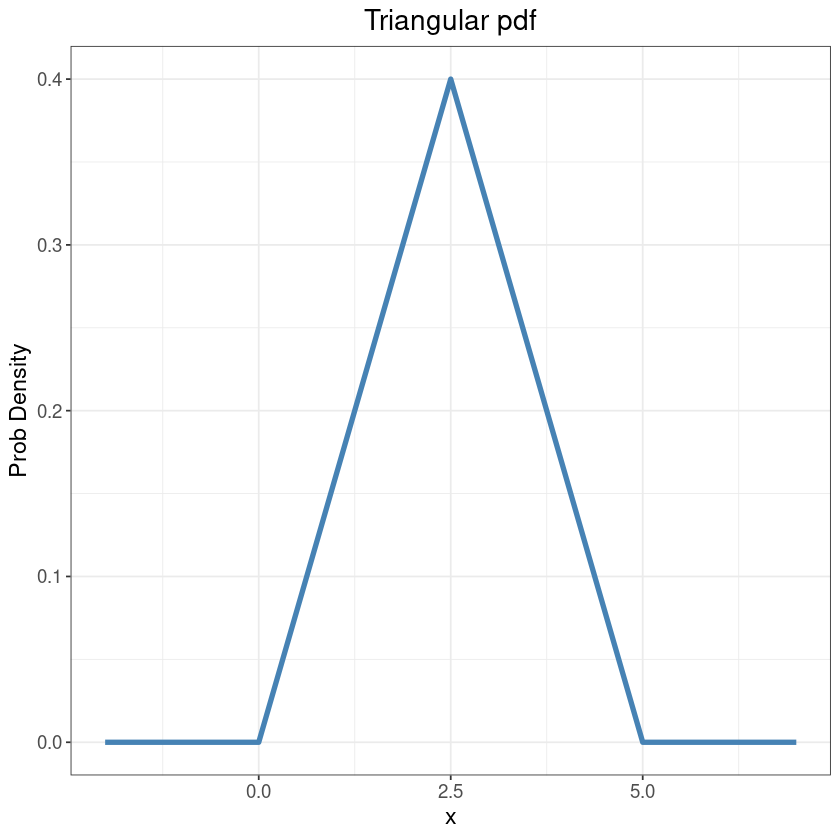

In [3]:
a <- 0
b <- 5
c <- (a+b)/2
x <- seq(a-2, b+2, 0.01)
# plot(x, triang(x,a,b,c))
pl <- ggplot()+
    geom_line(aes(x=x, y=triang(x,a,b,c)), color="steelblue", lwd=1.5) + 
    theme_bw() +
    labs(title="Triangular pdf", x="x",y="Prob Density")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5))
pl

There are two methon to generate number from a distribution: \
the first one is to go through the cumulative distribution, then to the inverse cdf and finally generating numbers from it;\
the second one is using the acception rejection method.

In [4]:
#how to generate random numbers from a continuous distribution
N <- 100
#integrating by hand the triangular pdf
triang_cdf <- function(x,a,b,c){
    if(a>b){return("Not valid input")}
    A <- 2/((b-a)*(c-a)) 
    B <- 2/((b-a)*(b-c))
    ifelse(x<a, 0,
        ifelse(x>=a & x < c,
        (0.5* x^2 - a*x + 0.5* a^2) * A,
        ifelse(x>=c & x<=b,
        (b*x - 0.5*x^2 -b*c + 0.5*c^2) * B + (0.5* c^2 - a*c + 0.5* a^2) * A, 
        #this traslational term is due to the fact that we have to add the left area of the triangle
        1)
    ) )
}

# plot(x, triang_cdf(x,a,b,c))

The function is invertible only in the interval [a,b] obviously

In [5]:
cdf_a <- triang_cdf(a,a,b,c)
cdf_c <- triang_cdf(c,a,b,c)
cdf_b <- triang_cdf(b,a,b,c)

inverse_cdf <- function(y, a,b,c){
    # if(y<0 & y>1){return("not valid input")}
    A <- 2/((b-a)*(c-a)) 
    B <- 2/((b-a)*(b-c))
    C <- A/2 * (c-a)^2  #F(c)
    ifelse(y>=cdf_a & y<cdf_c, a + sqrt(2*y/A), 
    ifelse(y>= cdf_c & y<=cdf_b, b - sqrt( (b-c)^2 - 2/B * (y-C) ), "invalid input" ) ) 
}

y<- seq(0,1,0.001)
# plot(y, inverse_cdf(y,a,b,c))

In [6]:
#random
r_func <- function(n){
    quant <- runif(n)
    v <- vector()
    for (q in quant){
        v <- append(v, inverse_cdf(q,a,b,c))
    }
    return(v)
}
samples <- r_func(10000)

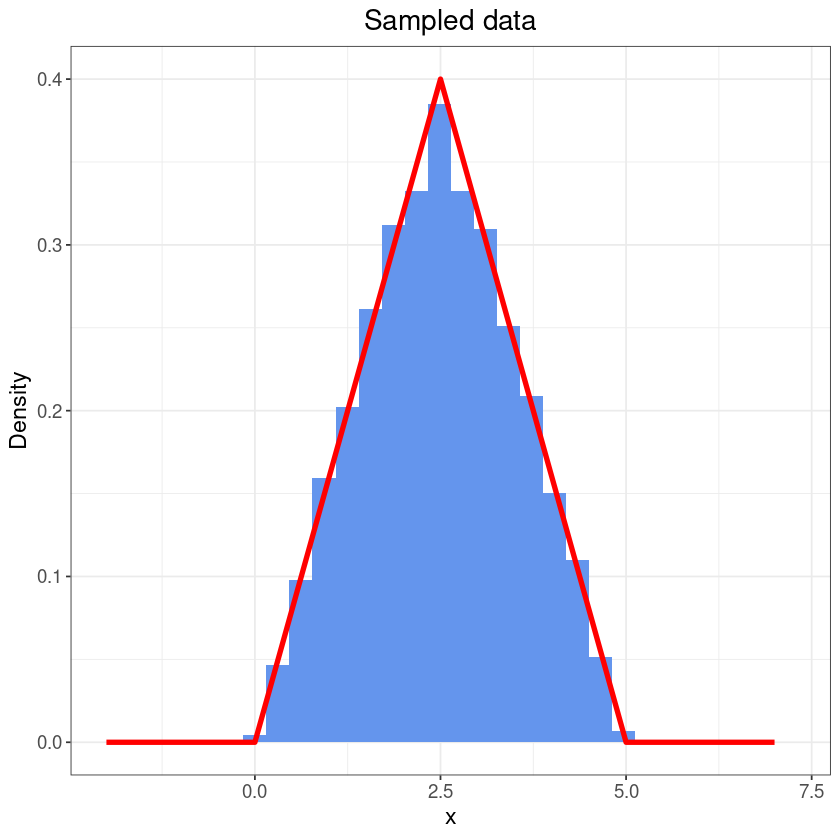

In [7]:
#plotting
triang_plot <- ggplot()+
    geom_histogram(aes(r_func(10000), y=..density..),bins=30, fill="cornflowerblue")+
    geom_line(aes(x=x, y=triang(x,a,b,c)), color="red", lwd=1.5) + 
    theme_bw() +
    labs(title="Sampled data", x="x",y="Density")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5))

triang_plot

Another approach is to use the "acception/rejection method". For a cdf defined in $[a,b]$:
- generate u1 ∈ U (0, 1)
- compute x1 = a + (b − a) · u1
- generate u2 ∈ U (0, 1)
- if u2 · M < f (x1) we accept and release x1
- otherwise we restart the algorithm

In [8]:
r_func2 <- function(n, a, b, c){
    M <- triang(c, a, b, c)
    sampled_list <- c()
    for (i in 1:n){
        repeat{
            u1 <- runif(1, 0, 1)
            x1 <- a + (b-a)*u1
            u2 <- runif(1, 0, 1)
            
            if(u2*M < triang(x1,a,b,c)){
                break;
            }
            # u1 <- runif(1, a, b)
            # u2 <- runif(1, 0, M)
            # if(triang(u1, a, b, c)>u2){
            #     break;
            # }
        }
        # sampled_list <- c(sampled_list, u1)
        sampled_list <- c(sampled_list, x1)
    }
    return (sampled_list)
}

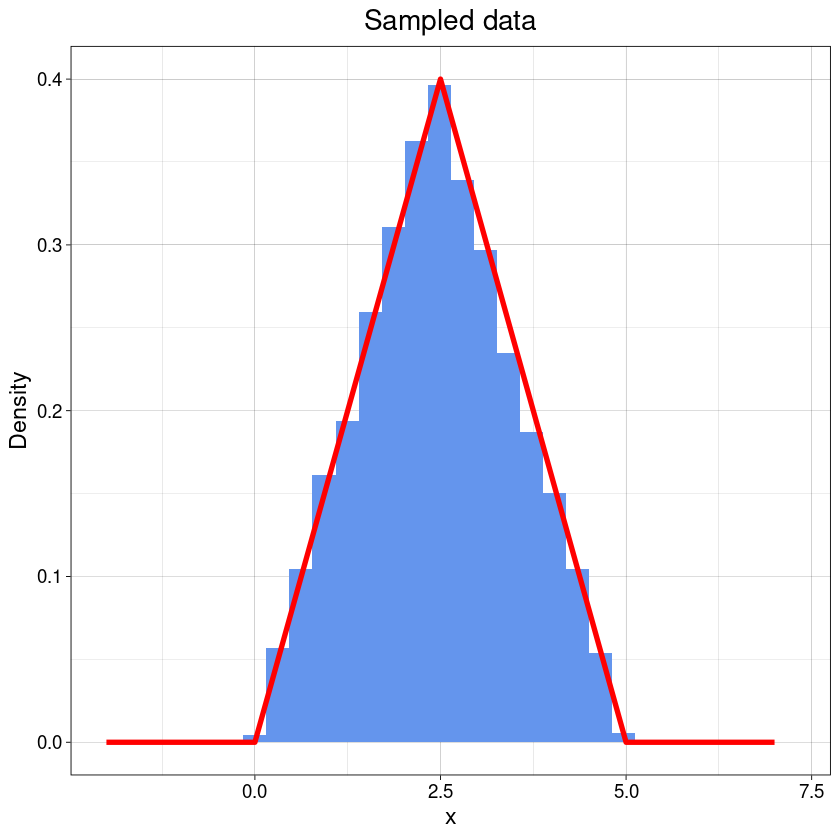

In [9]:
#plotting
triang_plot <- ggplot()+
    geom_histogram(aes(r_func2(10000,a,b,c), y=..density..),bins=30, fill="cornflowerblue")+
    geom_line(aes(x=x, y=triang(x,a,b,c)), color="red", lwd=1.5) + 
    theme_linedraw() +
    labs(title="Sampled data", x="x",y="Density")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5))

triang_plot

## es2


- Markov's upper bound (MUB) : 
- $G(k) =  1 - F(k) \equiv P(X > k)$


In [10]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 250)

# a) exponential
Mub <- function(E,k){
    return(E/k)
}

# we define also the G function which has as input the cdf
G <- function(k, fun){
    return(1 - match.fun(fun)(k) )
}

x <- seq(0, 10, 0.01)

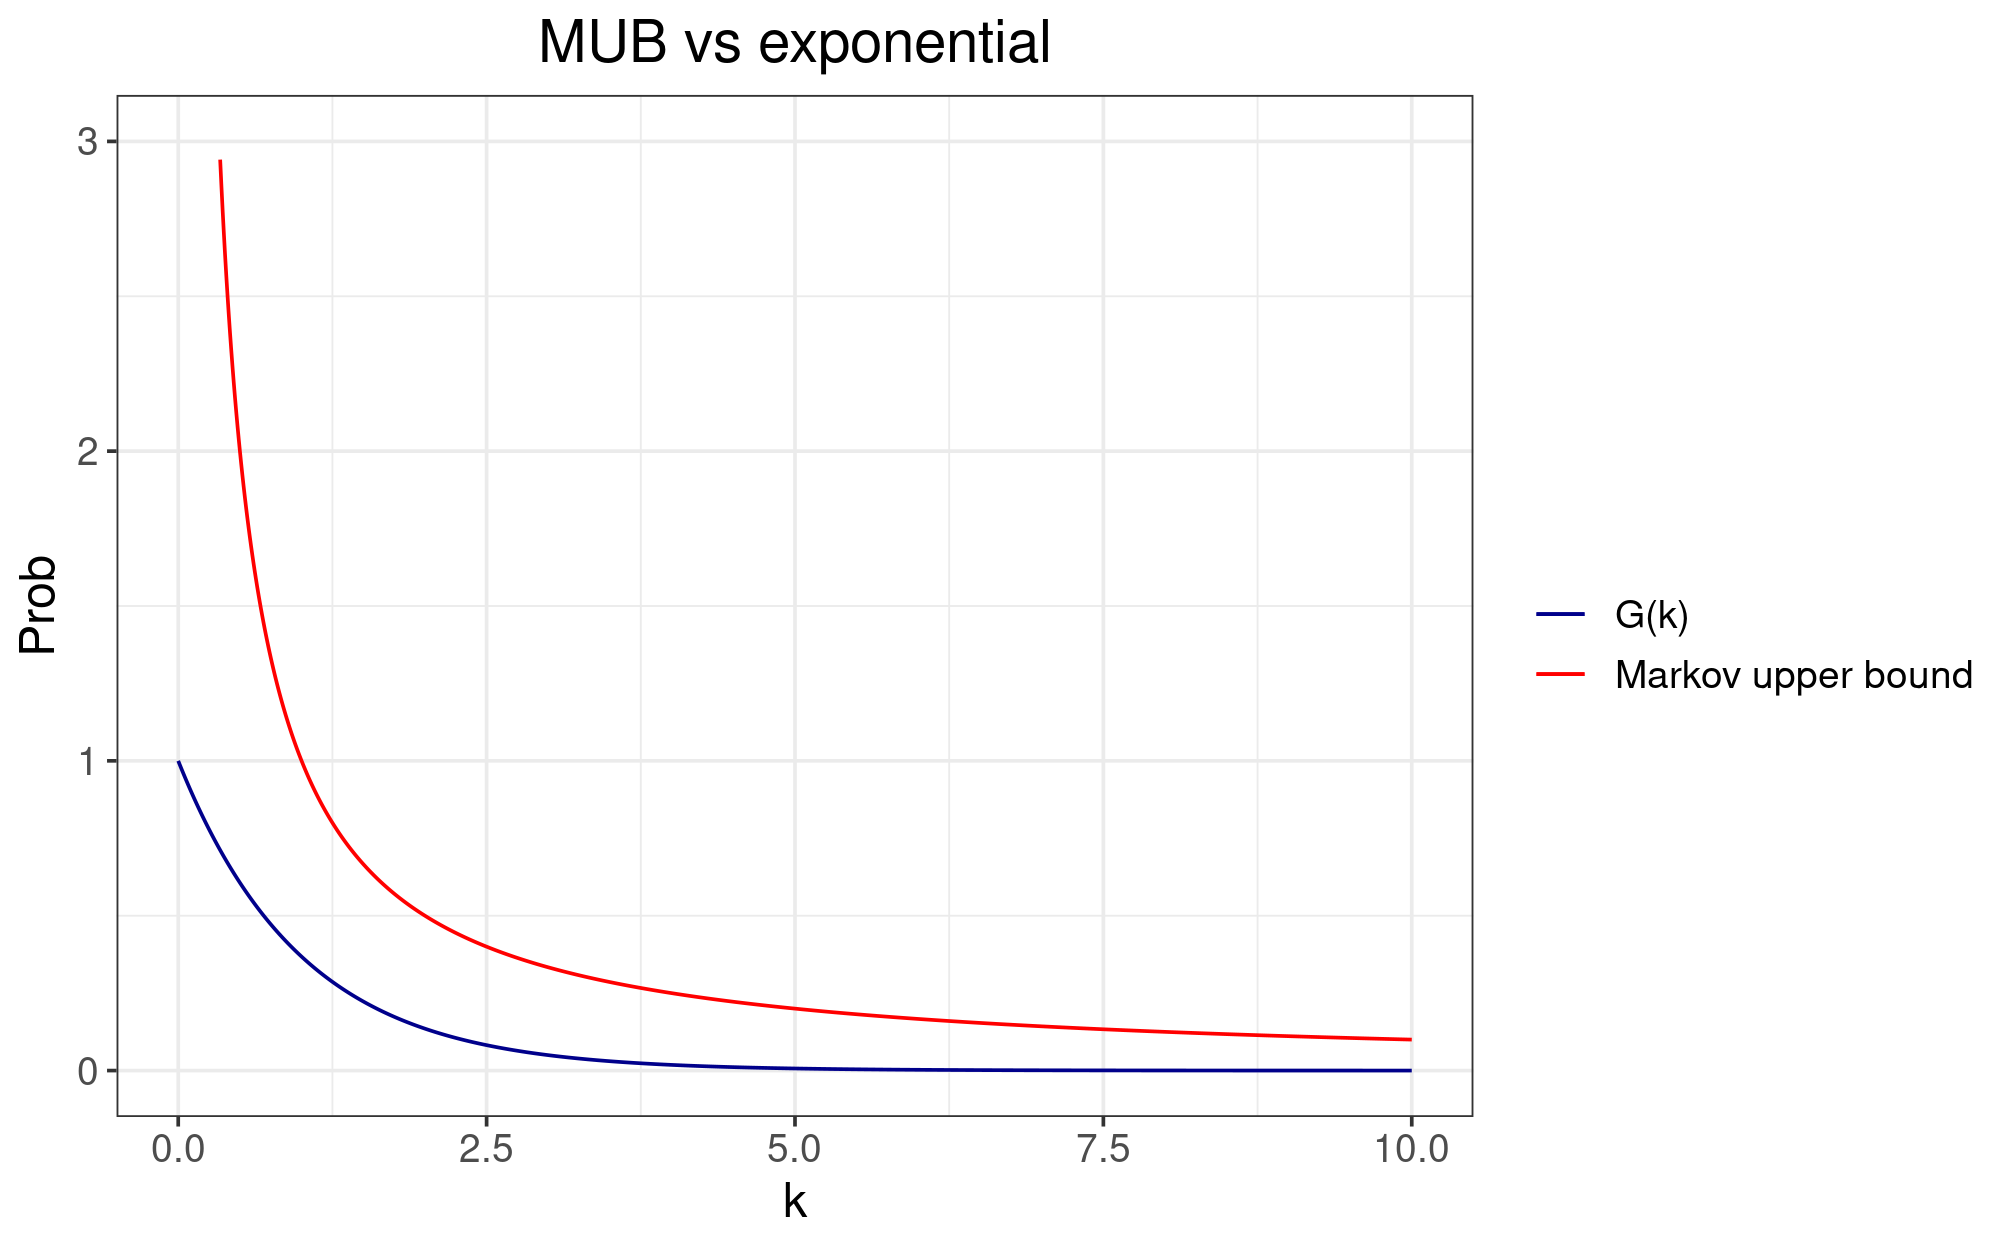

In [11]:
#EXPONENTIAL

lambda <- 1
# esp <- pexp(x, lambda) #F(x)
#recall that P(x>=k) = 1 - P(x<k)

exp_cdf <- function(k) {
    return( pexp(q=k, r=lambda))
}

E_esp <- 1/lambda


Mub_esp <- Mub(E_esp, x)
esp <- G(x, exp_cdf)

esp_plot <- ggplot()+
    geom_line(aes(x=x, y=esp, color="G(k)")) + 
    geom_line(aes(x=x, y=Mub_esp, color="Markov upper bound")) +
    scale_color_manual(name = "", values = c("G(k)" = "darkblue", "Markov upper bound" = "red"))+
    theme_bw() +
    labs(title="MUB vs exponential", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5))+
    ylim(0,3)

esp_plot

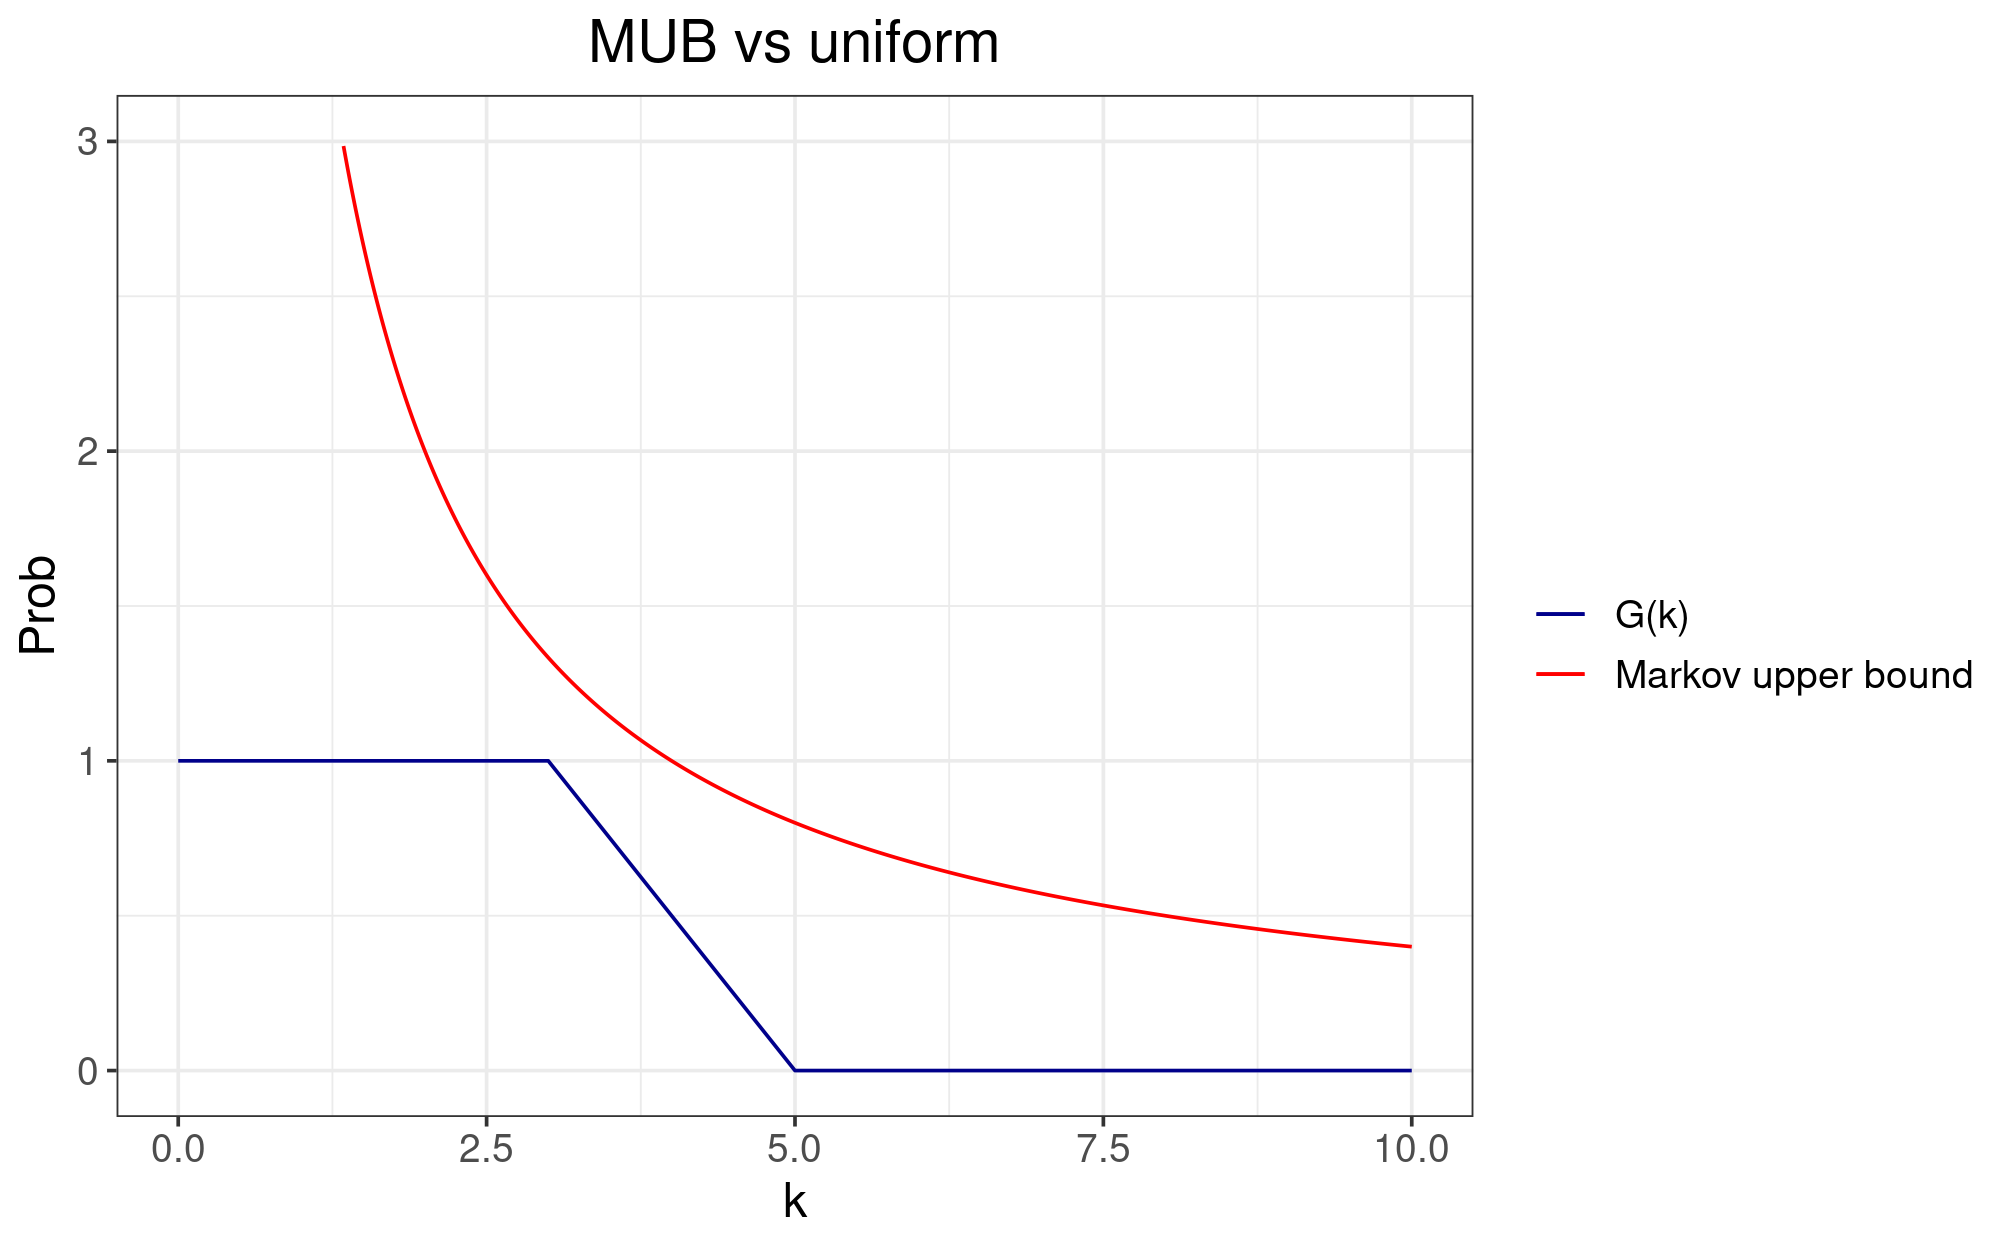

In [12]:
#UNIFORM 
min <- 3
max <- 5
uni_cdf <- function(k) {
    return( punif(q=k, min=3, max=5))
}
E_unif <- (min + max)/2
Mub_unif <- Mub(E_unif, x)
uni <- G(x, uni_cdf)

unifl_plot <- ggplot()+
    geom_line(aes(x=x, y=uni, color="G(k)")) + 
    geom_line(aes(x=x, y=Mub_unif, color="Markov upper bound")) +
    scale_color_manual(name = "", values = c("G(k)" = "darkblue", "Markov upper bound" = "red"))+
    theme_bw() +
    labs(title="MUB vs uniform", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,3)

unifl_plot

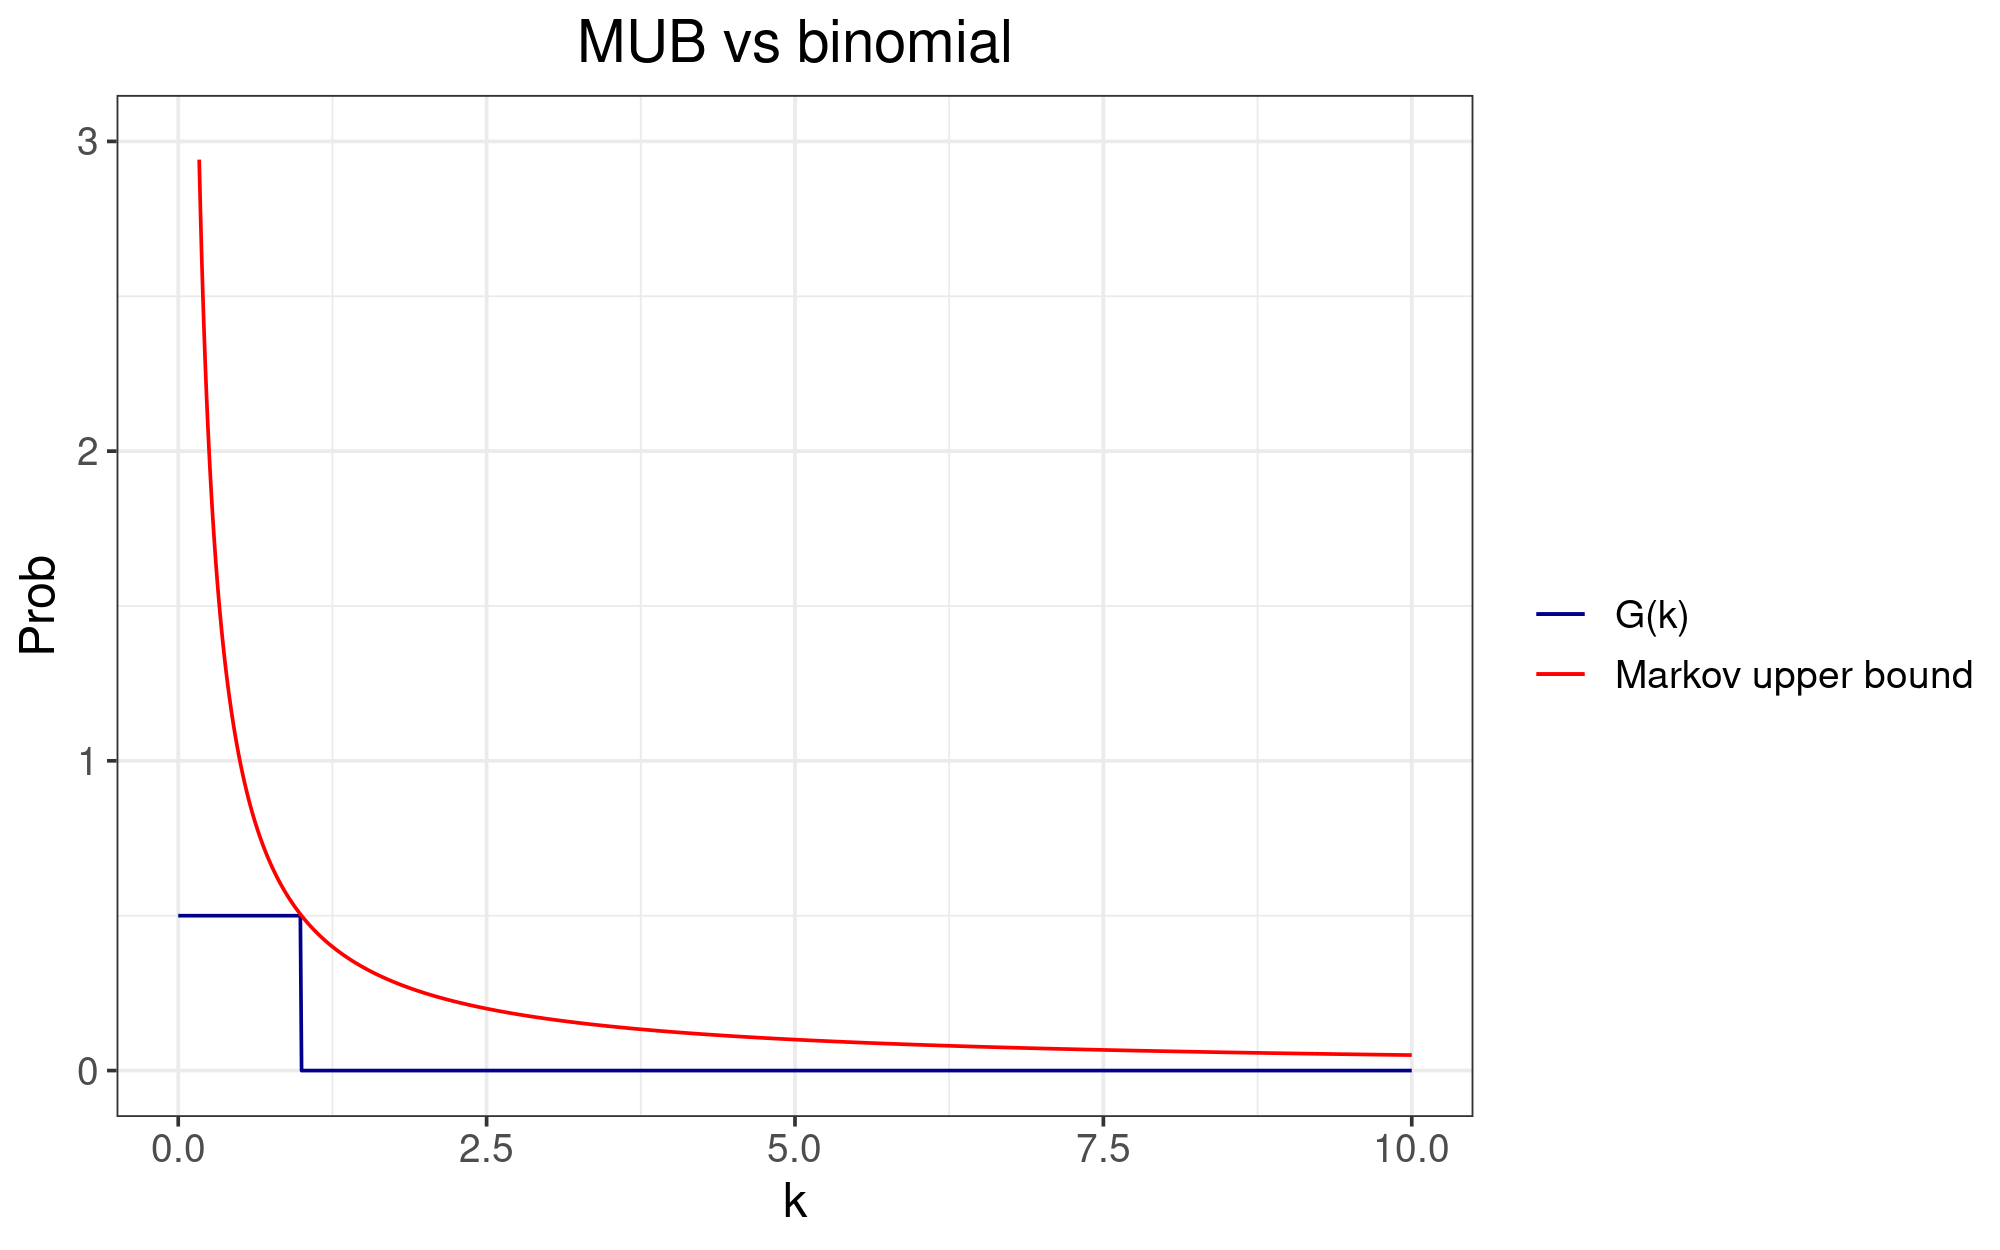

In [13]:
#BINOMIAL
p <- 1/2
bin_cdf <- function(k) {
    return( pbinom(q=k, size=1, prob = p))
}
E_bin <- p*1
Mub_bin <- Mub(E_bin, x)
bin <- G(x, bin_cdf)

bin_plot <- ggplot()+
    geom_line(aes(x=x, y=bin, color="G(k)")) + 
    geom_line(aes(x=x, y=Mub_bin, color="Markov upper bound")) +
    scale_color_manual(name = "", values = c("G(k)" = "darkblue", "Markov upper bound" = "red"))+
    theme_bw() +
    labs(title="MUB vs binomial", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,3)

bin_plot

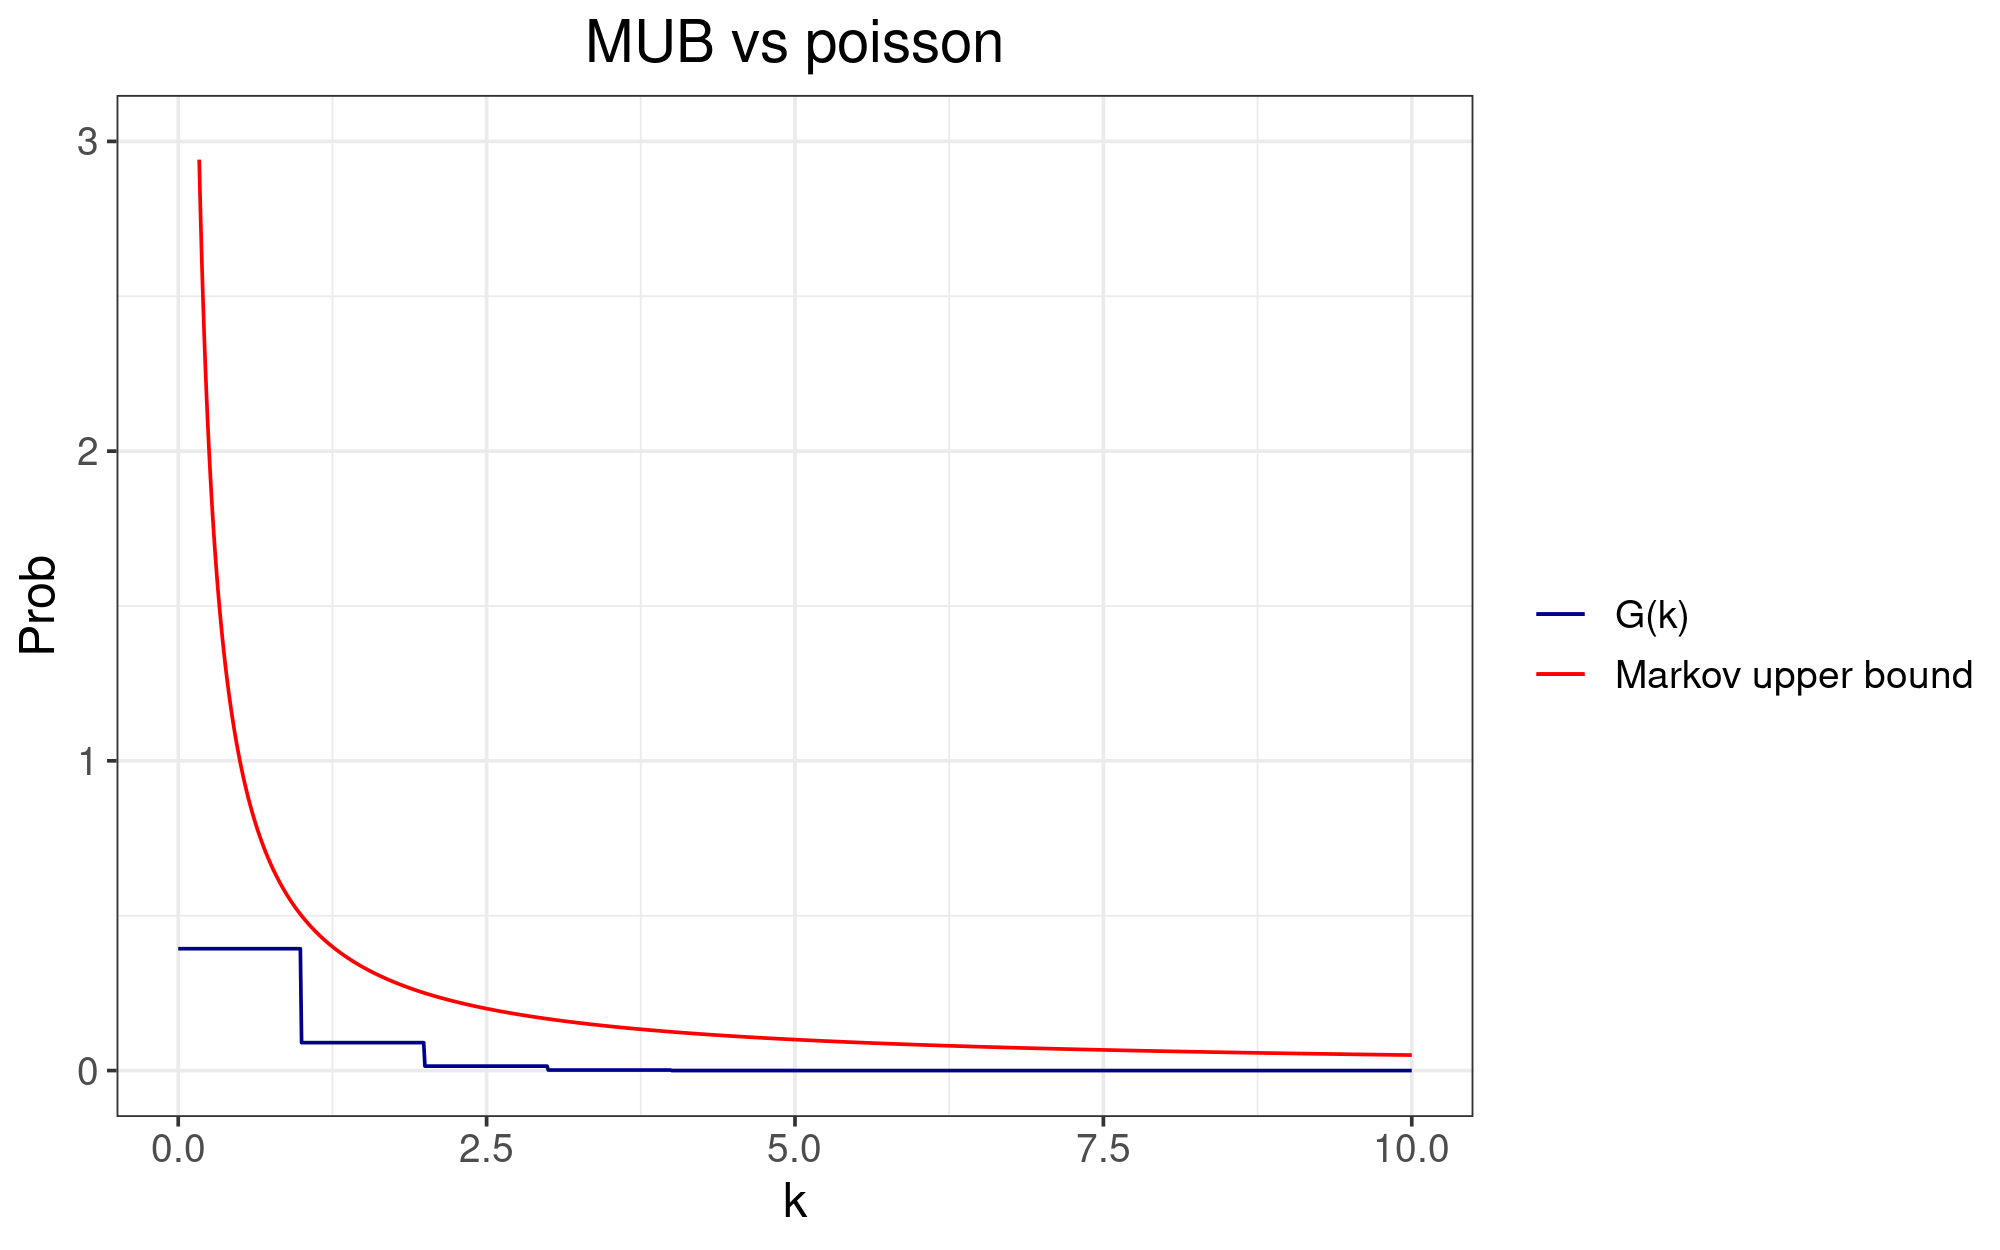

In [14]:
#POISSON
lambda <- 1/2
poi_cdf <- function(k) {
    return( ppois(q=k, lambda))
}
pois <- G(x,poi_cdf) #F(x)
E_pois <- lambda
Mub_pois <- Mub(E_pois, x)

pois_plot <- ggplot()+
    geom_line(aes(x=x, y=pois, color="G(k)")) + 
    geom_line(aes(x=x, y=Mub_pois, color="Markov upper bound")) +
    scale_color_manual(name = "", values = c("G(k)" = "darkblue", "Markov upper bound" = "red"))+
    theme_bw() +
    labs(title="MUB vs poisson", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,3)
pois_plot

## es3

In [15]:
Cub <- function(k) {
    return(1/ k^2)
}
G <- function(k, mu, sigma, fun) {
    return(1-match.fun(fun)(k*sigma + mu) + match.fun(fun)(-k*sigma + mu))
}

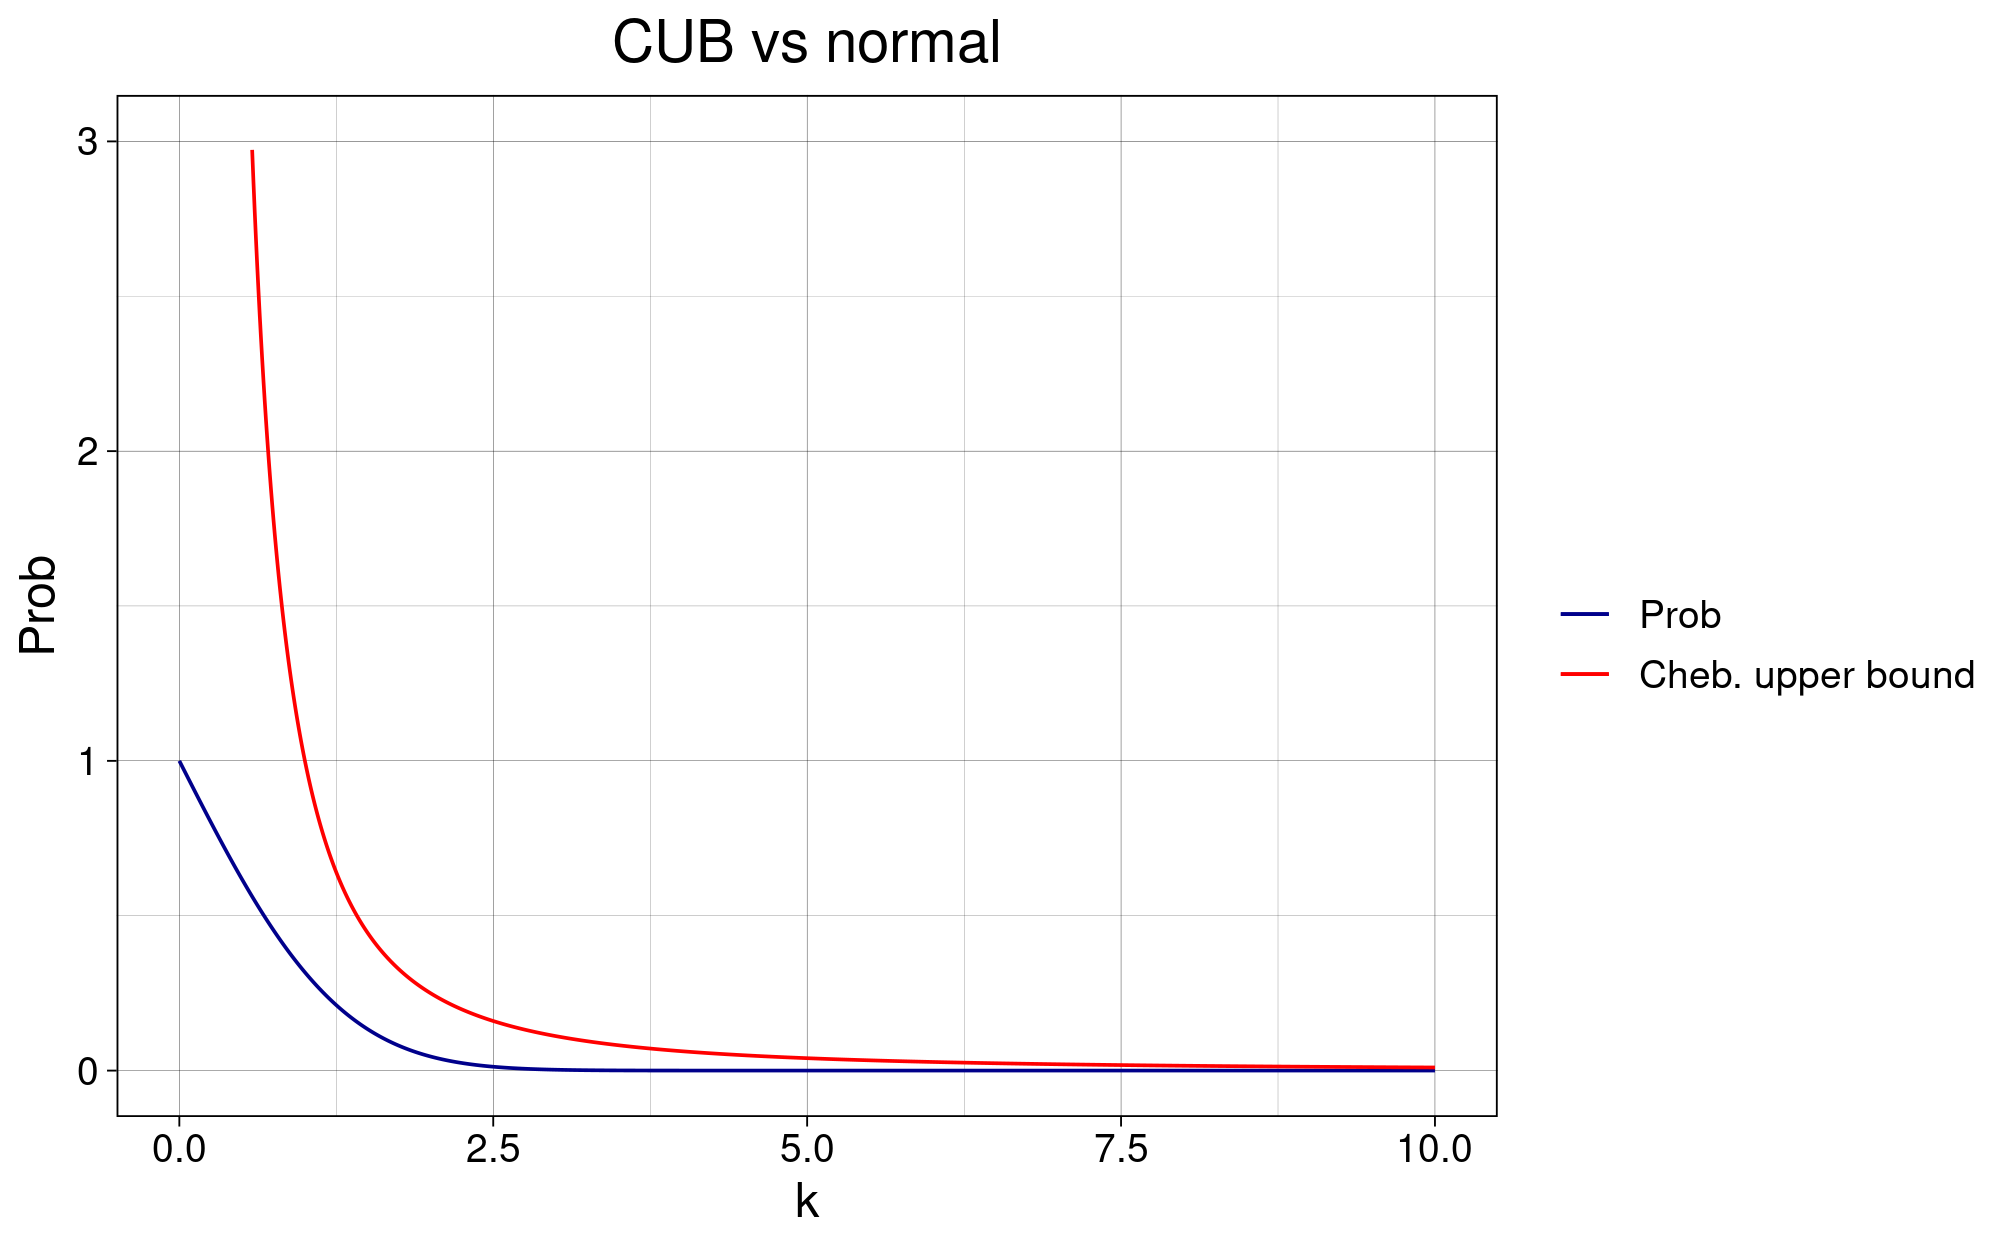

In [16]:
#NORMAL
mu <- 3
sigma <- 5

norm_cdf <- function(k){
    return(pnorm(q=k, mean=mu, sd=sigma))
}
gauss <- G(x, mu, sigma, norm_cdf)
gauss_cub <- Cub(x)

gauss_plot <- ggplot()+
    geom_line(aes(x=x, y=gauss, color="Prob")) + 
    geom_line(aes(x=x, y=gauss_cub, color="Cheb. upper bound")) +
    scale_color_manual(name = "", values = c("Prob" = "darkblue", "Cheb. upper bound" = "red"))+
    theme_linedraw() +
    labs(title="CUB vs normal", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,3)        
gauss_plot


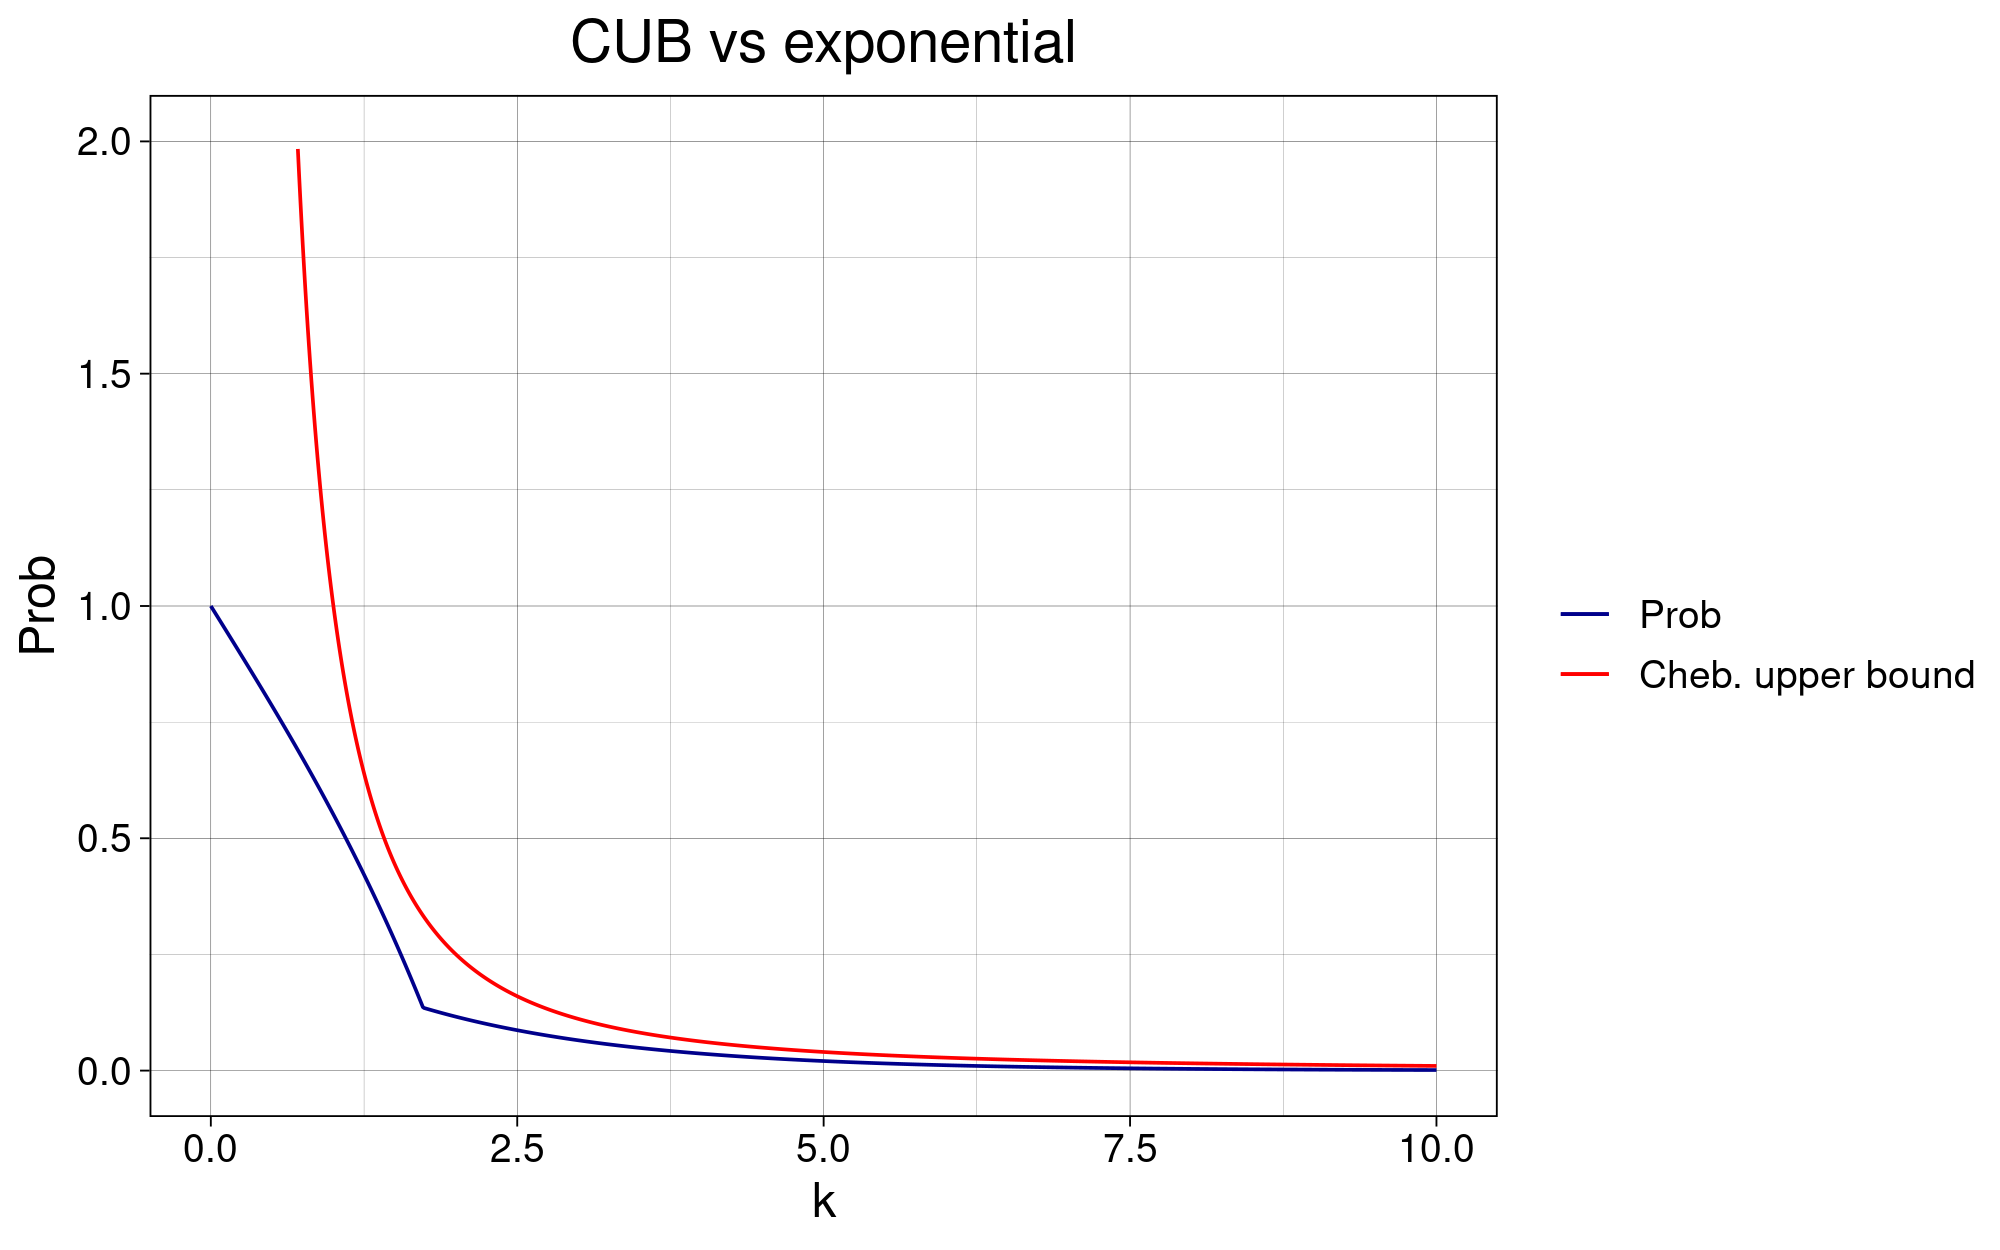

In [21]:
#EXP
l <- 1
exp_cdf <- function(k){ 
    return(pexp(q=k, r=l))}
    
exp_mean <- 1/l
exp_var <- 1/l^2

esp <- G(x, mu, var, exp_cdf)
esp_cub <- Cub(x)

esp_plot <- ggplot()+
    geom_line(aes(x=x, y=G(x, mu, var, exp_cdf), color="Prob")) + 
    geom_line(aes(x=x, y=gauss_cub, color="Cheb. upper bound")) +
    scale_color_manual(name = "", values = c("Prob" = "darkblue", "Cheb. upper bound" = "red"))+
    theme_linedraw() +
    labs(title="CUB vs exponential", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,2)        
esp_plot

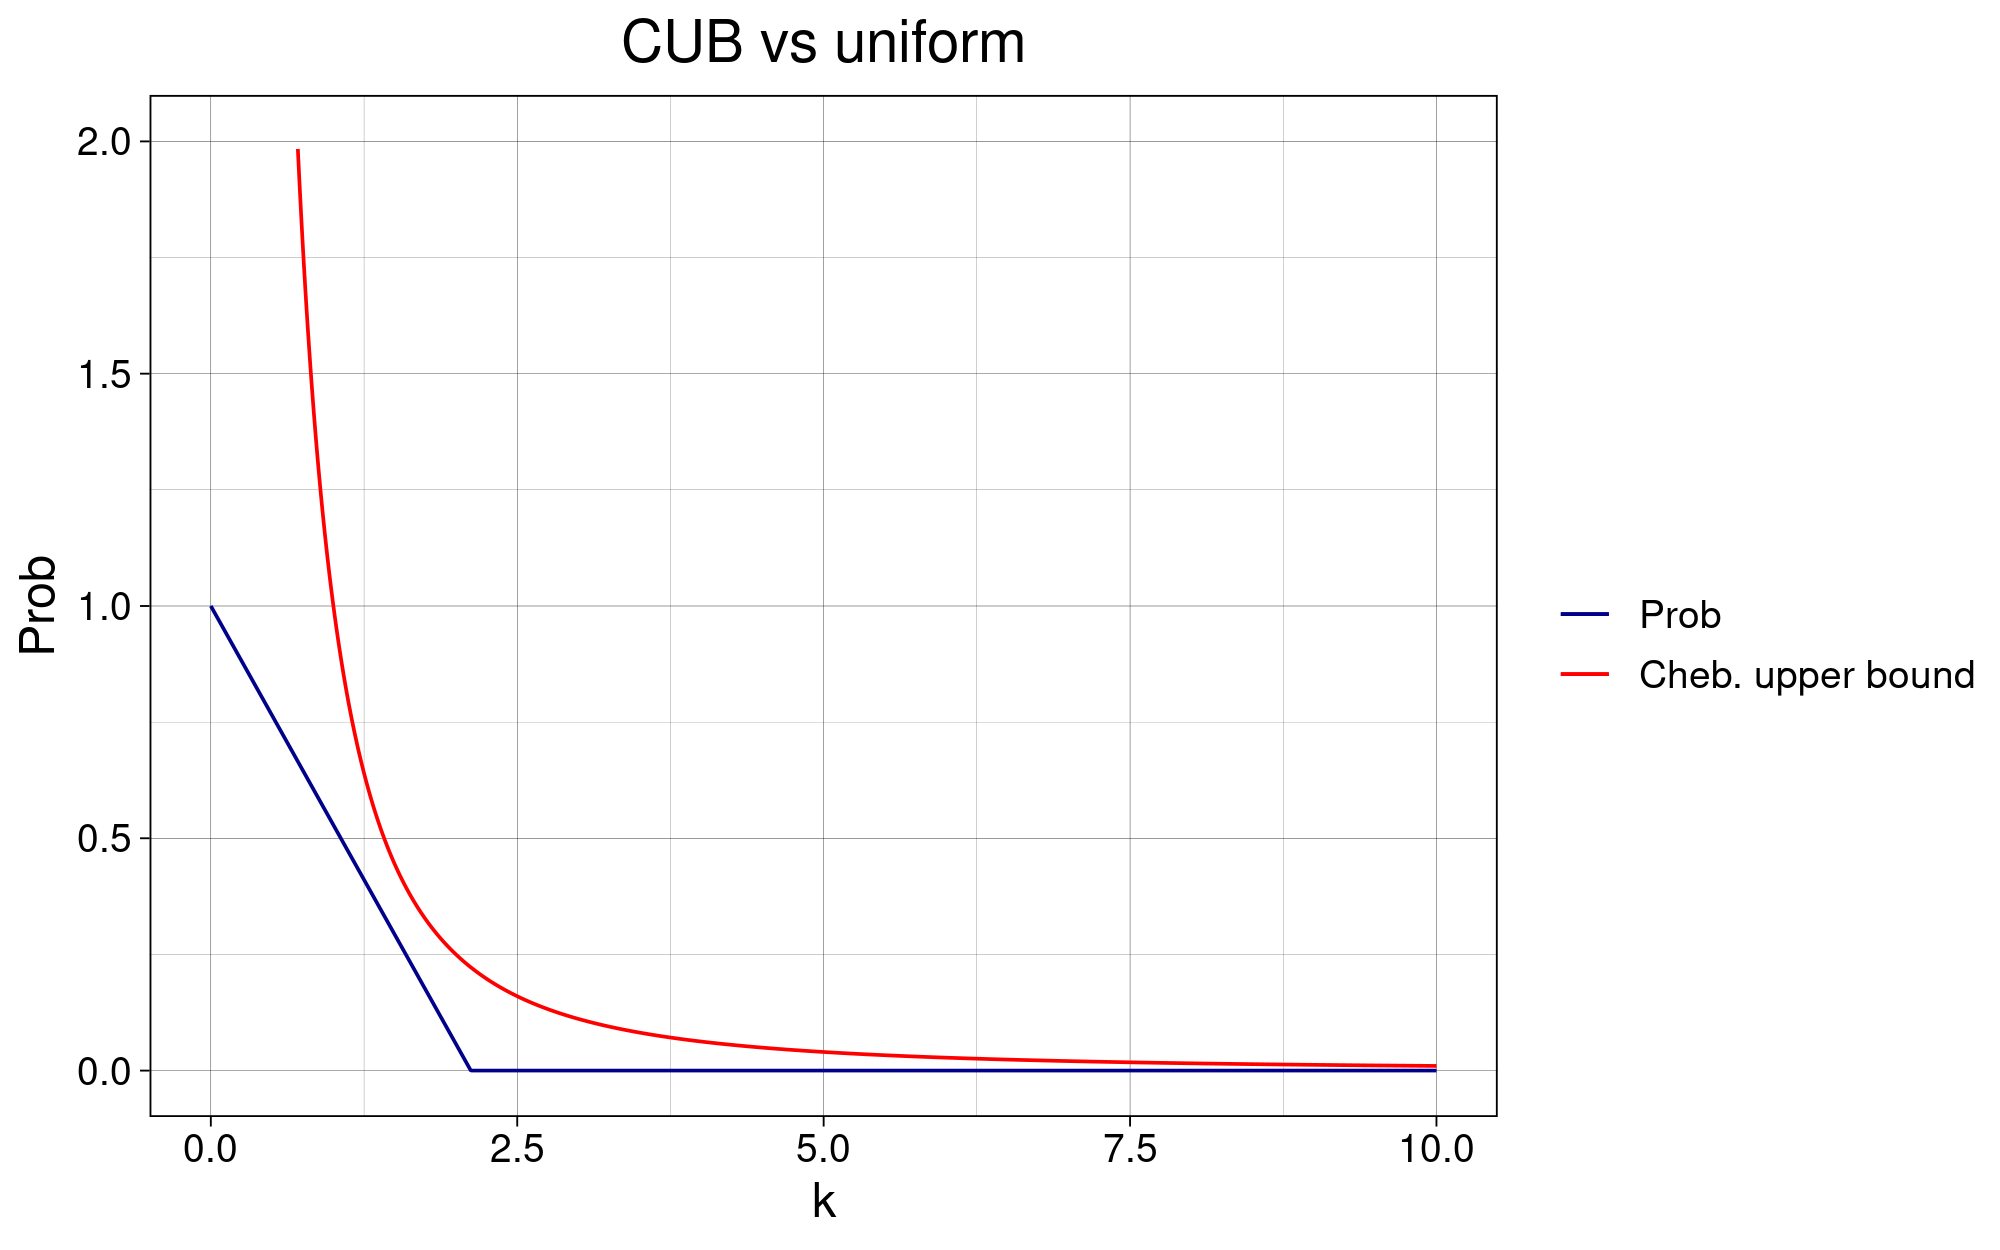

In [18]:
#UNIF
min <- 1-sqrt(2)
max <- 1+sqrt(2)
mu <- (min+max)/2
var <- (min-max)^2 /12

unif_cub <- Cub(x)
uni_cdf  <- function(k){ return(punif(q=k, min=min, max=max))}

uni_plot <- ggplot()+
    geom_line(aes(x=x, y=G(x, mu, var, uni_cdf), color="Prob")) + 
    geom_line(aes(x=x, y=gauss_cub, color="Cheb. upper bound")) +
    scale_color_manual(name = "", values = c("Prob" = "darkblue", "Cheb. upper bound" = "red"))+
    theme_linedraw() +
    labs(title="CUB vs uniform", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,2)        
uni_plot


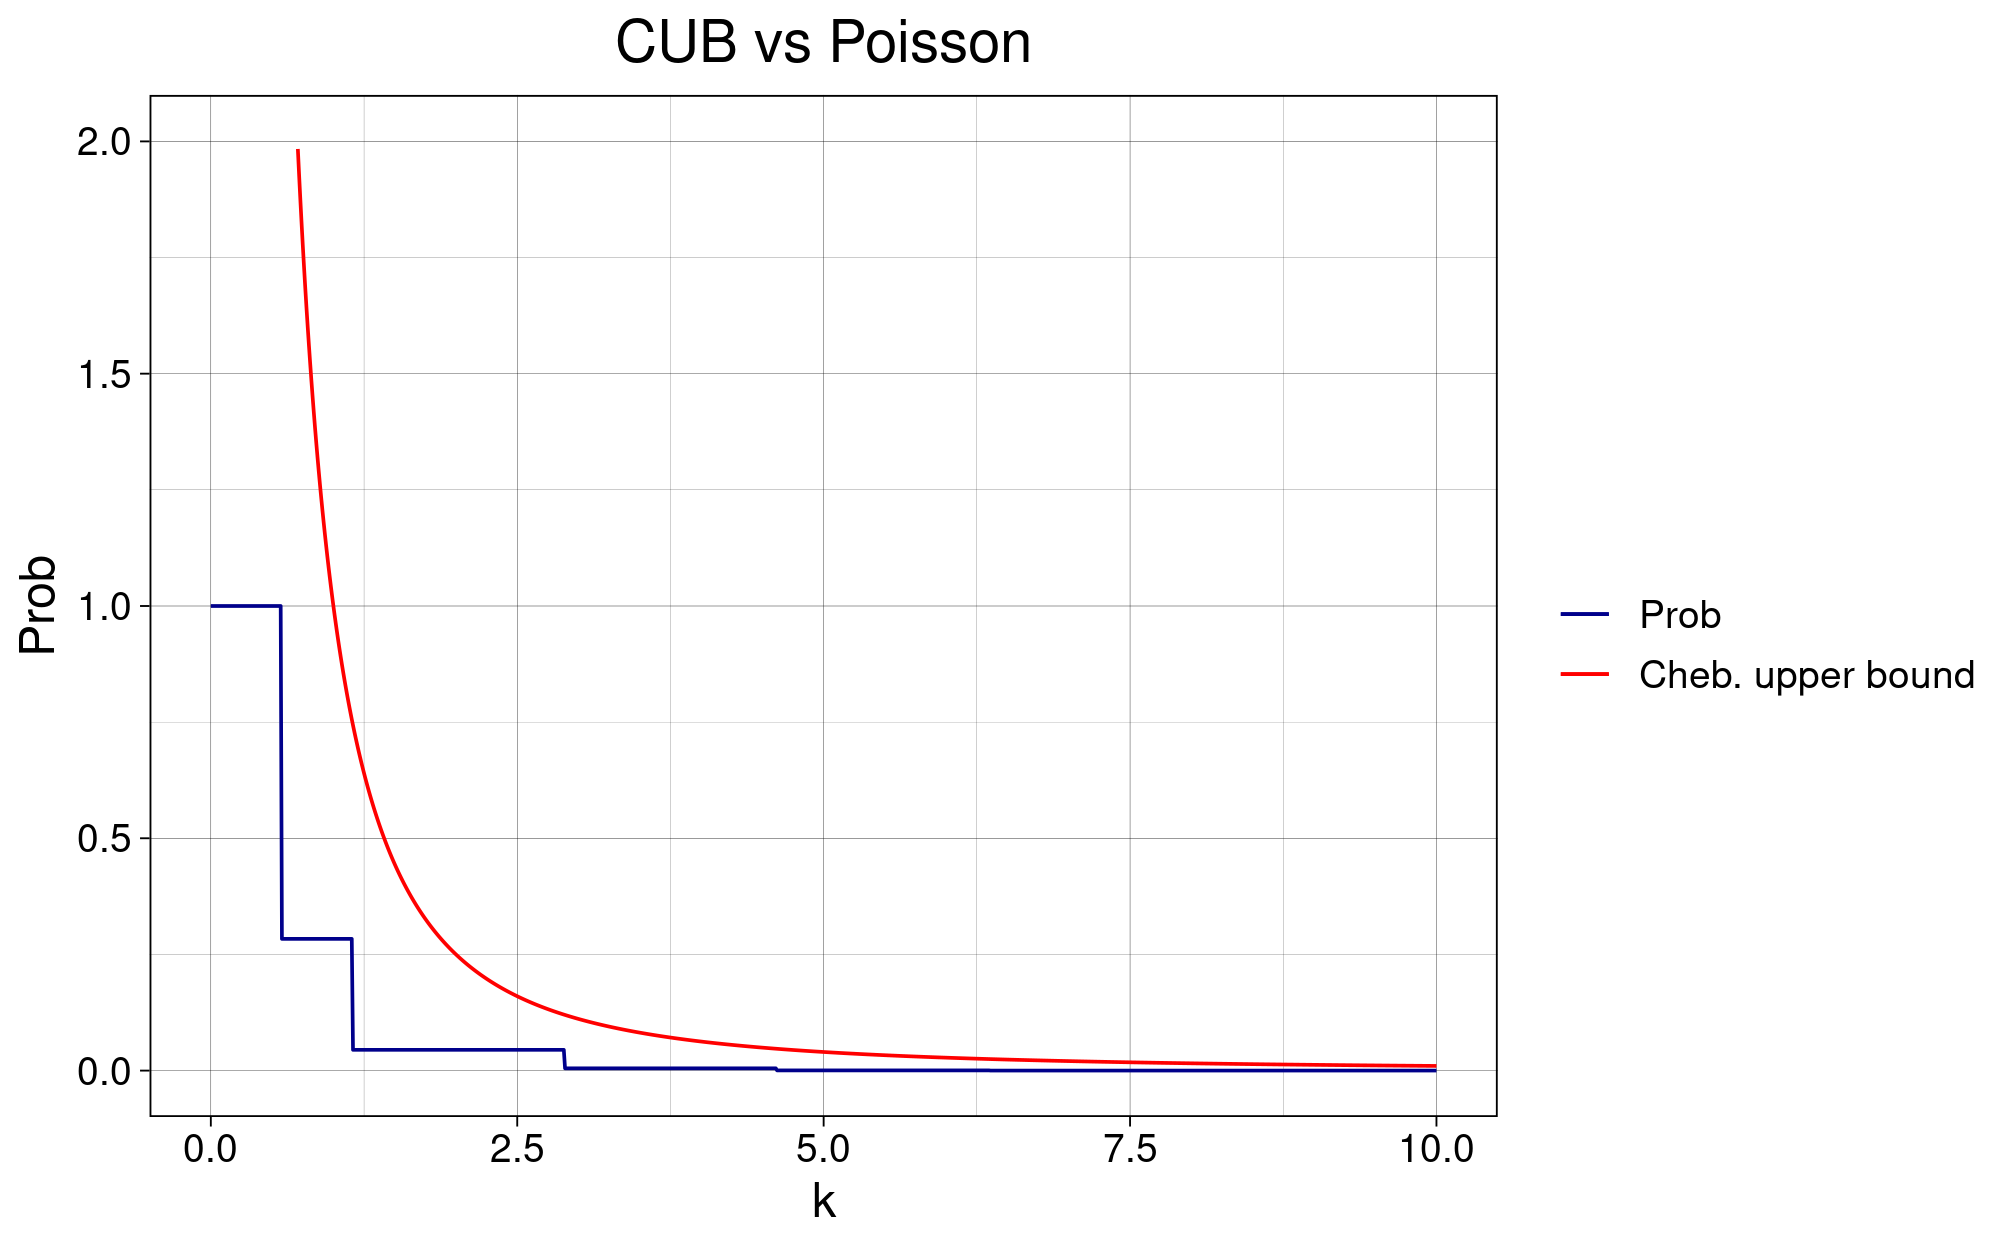

In [19]:
#POISSON
lambda <- 1/3
poi_cdf <- function(k) {
    return( ppois(q=k, lambda))
}
E_pois <- lambda
var <- sqrt(lambda)


uni_plot <- ggplot()+
    geom_line(aes(x=x, y=G(x, E_pois, var, poi_cdf), color="Prob")) + 
    geom_line(aes(x=x, y=gauss_cub, color="Cheb. upper bound")) +
    scale_color_manual(name = "", values = c("Prob" = "darkblue", "Cheb. upper bound" = "red"))+
    theme_linedraw() +
    labs(title="CUB vs Poisson", x="k",y="Prob")+
    theme(text = element_text(size=14), plot.title = element_text( hjust = 0.5)) +
    ylim(0,2)        
uni_plot


## es4
Exercise 4 - Six Boxes Toy Model : inference

The goal is to calculate the probability of each box after each extraction: $P(H_i | I)$. In order to do that we use the Bayes' theorem such that:
\begin{equation}
P(H_i | I) = \frac{P(E^{(n)} | H_j I_{n-1} ) \>\> P(H_j|I_{n-1})}{
    \sum_i P(E^{(n)} | H_i I_{n-1} ) \>\> P(H_i|I_{n-1})
}
\end{equation}
where n refers to the n-th extraction, while $P(E^{(n)} | H_j I_{n-1})$ is the prob of a W/B stone in the box $H_j$. Since this probability is different depending on the color of the stone:
\begin{equation}
P(E_k | H_j I) =     
    \begin{cases}
        j/5    & if \> k=white\\
        1-j/5  & if \> k=black
    \end{cases}
\end{equation}
we have to find a way in order to include both case in the same formula. So considering that we will ude binary code fot the color (0 for white, and 1 for black), we can use:
\begin{equation}
P(E_k | H_j I) = |k - j/5| 
\end{equation}
where j refers to the number of white stones in the box (or the index of the box) and k is 0,1 depending on the color of the extracted stone.

The Bayes' theorem formula can be splitted in different factors: Prior, Evidence, Posterior such that:
\begin{equation}
posterior = \frac{likelihood \times prior}{evidence}
\end{equation}
so to calculate the posterior we need to evaluate likelihood, prior and evidence.

The code is splitted in two parts: the first one consists on defing all the functions that are needed: function for the calculation of the posterior, for reading the user's input of the extraction; the second part consists on connecting all these function to repeat the extractions and calculate every probabilities



In the read_input function all the print are due to the fact that I'm using visual studio code which doesn't give a view to track the input

In [23]:
#this function read the result ofthe extraction
read_input <- function(){
    ext <- readline(prompt="Insert the extraction")
    cat("Extraction: white(w), black(b) or to stop (s): ",ext,"\n")

    if(ext == "w") x <- 0
    else{
        if(ext == "b") x <- 1
        else x <-NA
    }
    if(ext == "s") flag <- FALSE
    else flag <- TRUE
    
    return(c(x,flag))
}

In [24]:
posterior <- function(prior, extr) {
    j <- 0:5 #indexes of the box
    likelihood <- vector()
    likelihood <- abs(extr - j/5)
    evidence <- sum(likelihood*prior)
    return(likelihood*prior/evidence) #returns the Bayes' formula
}

In [25]:
#main
flag <- TRUE
#initialize all the initial prior => 1/6 same prob for each box
prior <- rep(1/6, times=6)
#initialize the dataframe that keep track the prob at each extraction
df <- data.frame(matrix(nrow = 1, ncol = 6))
colnames(df) <- c("H0","H1","H2","H3","H4","H5")
df[1,] <- prior
n_ext <- 0

while(flag){
    input <- read_input()
    flag <- input[2]
    color <- input[1]
    n_ext <- n_ext  + 1 #number of extraction
    if(!is.na(color)){ #if we say stop to the input function it return na so we need this condition
        prior <- unlist(tail(df,1)) #the prior has to be update every loop -> last row of df
        post <- posterior(prior, color)
        #then we add the posterior to the df
        df[nrow(df) +1,] <- post
        # print(df)

    }
}
df

Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  w 
Extraction: white(w), black(b) or to stop (s):  w 
Extraction: white(w), black(b) or to stop (s):  w 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  w 
Extraction: white(w), black(b) or to stop (s):  w 
Extraction: white(w), black(b) or to stop (s):  b 
Extraction: white(w), black(b) or to stop (s):  s 


,H0,H1,H2,H3,H4,H5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1666667,0.16666667,0.16666667,0.16666667,0.166666667,0.1666667
2,0.3333333,0.26666667,0.20000000,0.13333333,0.066666667,0.0000000
3,0.4545455,0.29090909,0.16363636,0.07272727,0.018181818,0.0000000
4,0.5555556,0.28444444,0.12000000,0.03555556,0.004444444,0.0000000
5,0.6384065,0.26149132,0.08273749,0.01634321,0.001021450,0.0000000
6,0.0000000,0.54468085,0.34468085,0.10212766,0.008510638,0.0000000
7,0.0000000,0.34594595,0.43783784,0.19459459,0.021621622,0.0000000
8,0.0000000,0.18285714,0.46285714,0.30857143,0.045714286,0.0000000
9,0.0000000,0.26283368,0.49897331,0.22176591,0.016427105,0.0000000


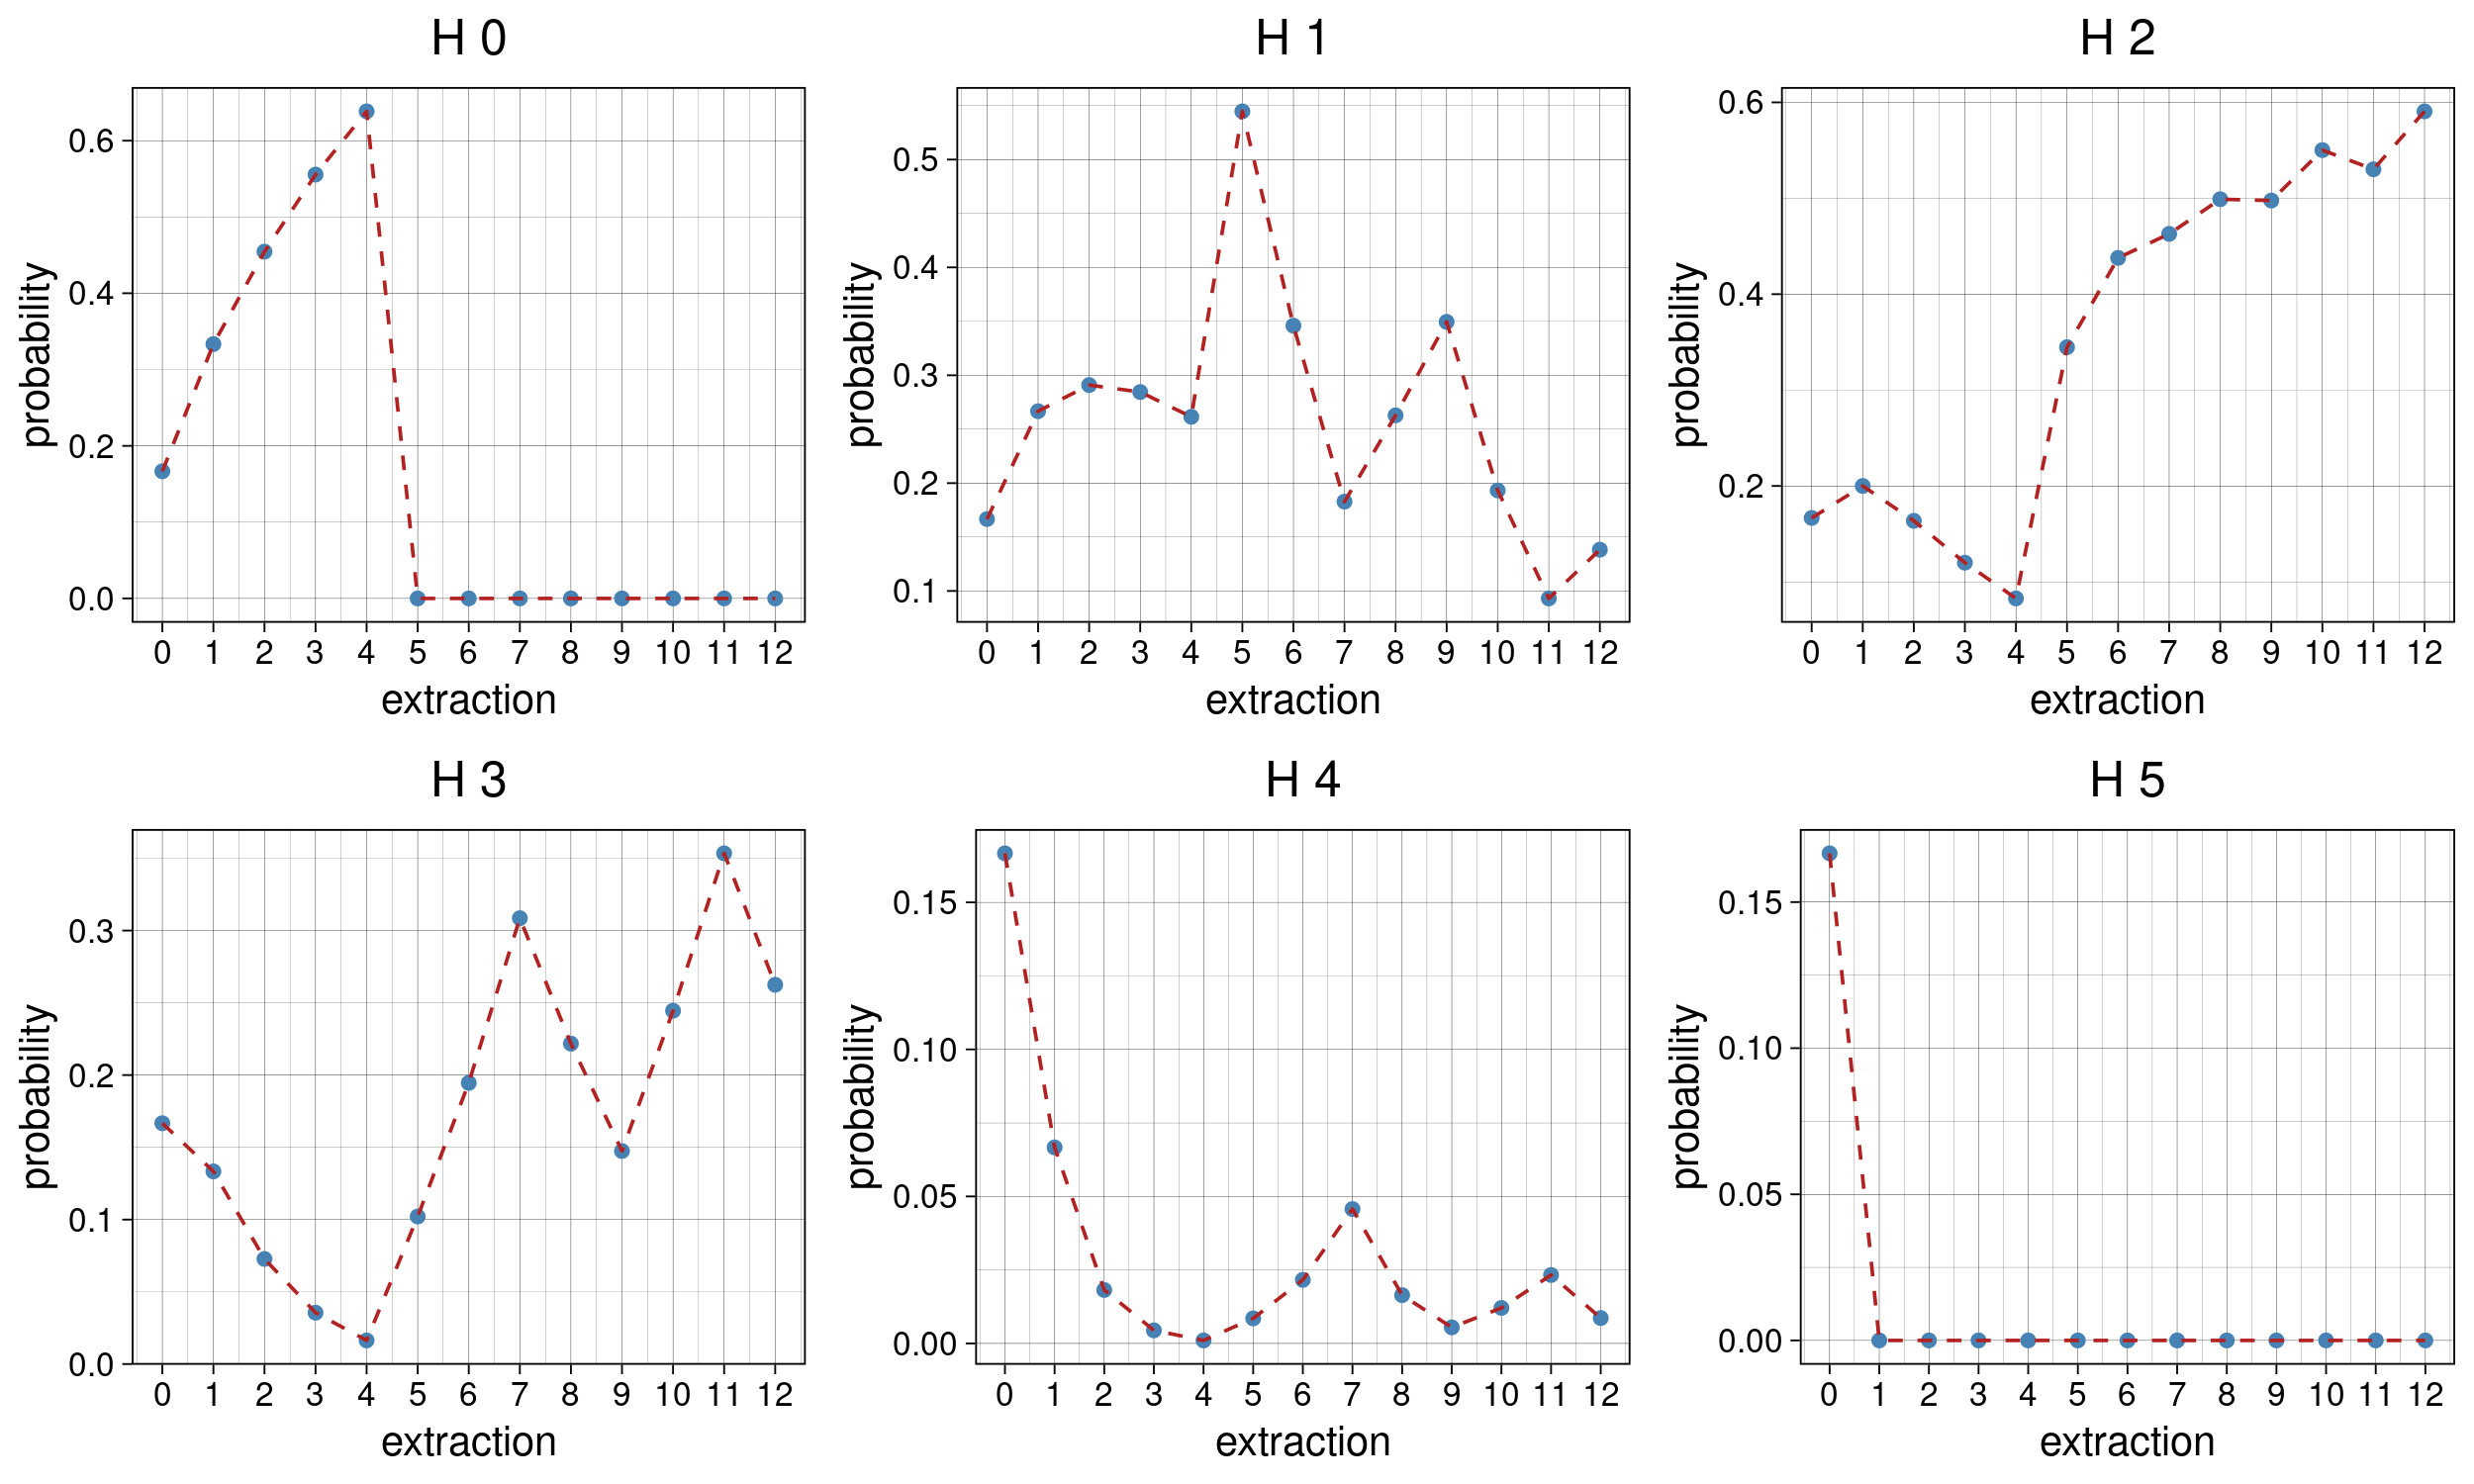

In [26]:
#plot
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 250)

j <- 0:(n_ext-1)
plots <- list()
for (i in 0:5 ){
    plot <- ggplot() +
                geom_point(aes(j, df[,(i+1)]), color="steelblue")+
                geom_line(aes(j, df[,(i+1)]), color="firebrick", linetype="dashed")+
                theme_linedraw()+
                labs(x="extraction", y="probability")+
                ggtitle(paste("H",i))+
                scale_x_continuous(breaks=j)+
                theme(plot.title = element_text(hjust = 0.5), text=element_text(size=12))
    
    plots[[i+1]] = ggplotGrob(plot)
    
}
grid.arrange(grobs=plots, ncol=3, nrow=2)

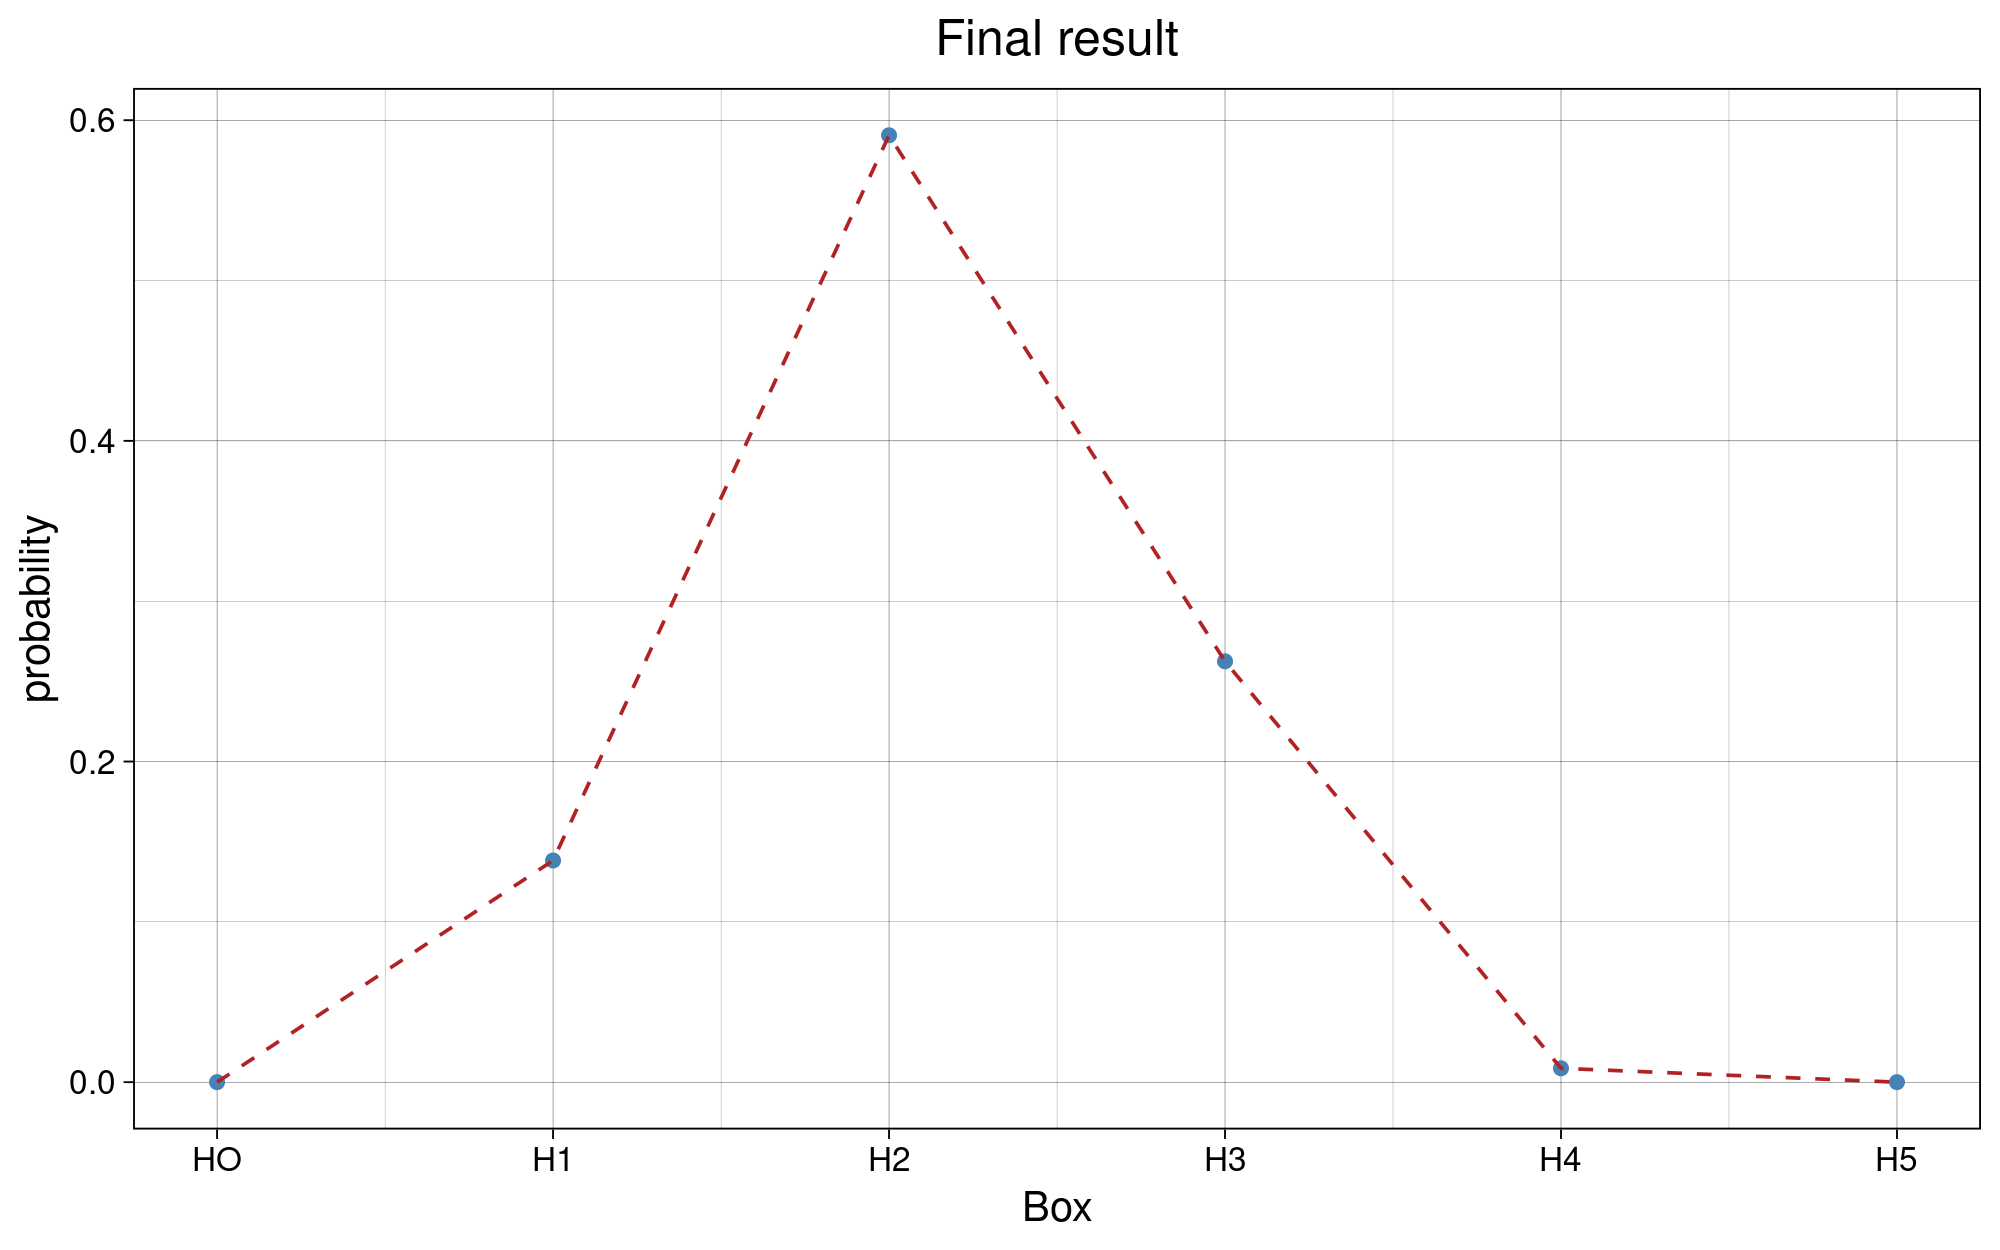

In [27]:
#Plotting the final prior at the end of the extraction
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 250)

box <- 0:5
plot <- ggplot() +
            geom_point(aes( box , unlist(tail(df,1))), color="steelblue")+
            geom_line(aes(box , unlist(tail(df,1))), color="firebrick", linetype="dashed")+
            theme_linedraw()+
            labs(title = "Final result",x="Box", y="probability")+
            theme(plot.title = element_text(hjust = 0.5), text=element_text(size=12))+
            scale_x_continuous(breaks=box, labels=c("HO","H1","H2","H3","H4","H5"))

plot

## es5:
### simulation of 6-box
Mostly of the code is taken from the previous exercize. Here we select randomly a box, then the user select how many random extraction will be done and the program will extract randomly n stones and print the color of it. Finally we calculate every probability as the previous exercize.

In [ ]:
# for the box selection we use sample
white <- sample(0:5,1) #we select the H_white box

# now we construct the box.. 
box <- c(rep(0, white), rep(1,5-white))
#...and the function for the random extraction from it
extraction <- function(box){
    sample(box,1)
}

print_color <- function(ext){
    if(ext == 1){print("w")}
    if(ext == 0){print("b")}
}

prior <- rep(1/6, times=6)
df <- data.frame(matrix(nrow = 1, ncol = 6))
colnames(df) <- c("H0","H1","H2","H3","H4","H5")
df[1,] <- prior

n_ext <- readline(prompt="Insert the number of extraction")
n_ext <- strtoi(n_ext, base = 0L)
print("The number of extraction is", n_ext)

print("The color of the extracted ball:")

for (i in 1:n_ext ){
    ext <- extraction(box)
    print_color(ext)
    prior <- unlist(tail(df,1))
    post <- posterior(prior, ext)
    df[nrow(df) +1,] <- post

}
df

[1] "The number of extraction is"
[1] "The color of the extracted ball:"
[1] "w"
[1] "b"
[1] "w"
[1] "b"
[1] "b"
[1] "b"
[1] "b"
[1] "b"
[1] "b"
[1] "b"


,H0,H1,H2,H3,H4,H5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1666667,0.1666666667,0.16666667,0.1666667,0.16666667,0.1666667
2,0.3333333,0.2666666667,0.20000000,0.1333333,0.06666667,0.0000000
3,0.0000000,0.2000000000,0.30000000,0.3000000,0.20000000,0.0000000
4,0.0000000,0.3200000000,0.36000000,0.2400000,0.08000000,0.0000000
5,0.0000000,0.1538461538,0.34615385,0.3461538,0.15384615,0.0000000
6,0.0000000,0.0615384615,0.27692308,0.4153846,0.24615385,0.0000000
7,0.0000000,0.0216216216,0.19459459,0.4378378,0.34594595,0.0000000
8,0.0000000,0.0069565217,0.12521739,0.4226087,0.44521739,0.0000000
9,0.0000000,0.0021041557,0.07574961,0.3834824,0.53866386,0.0000000


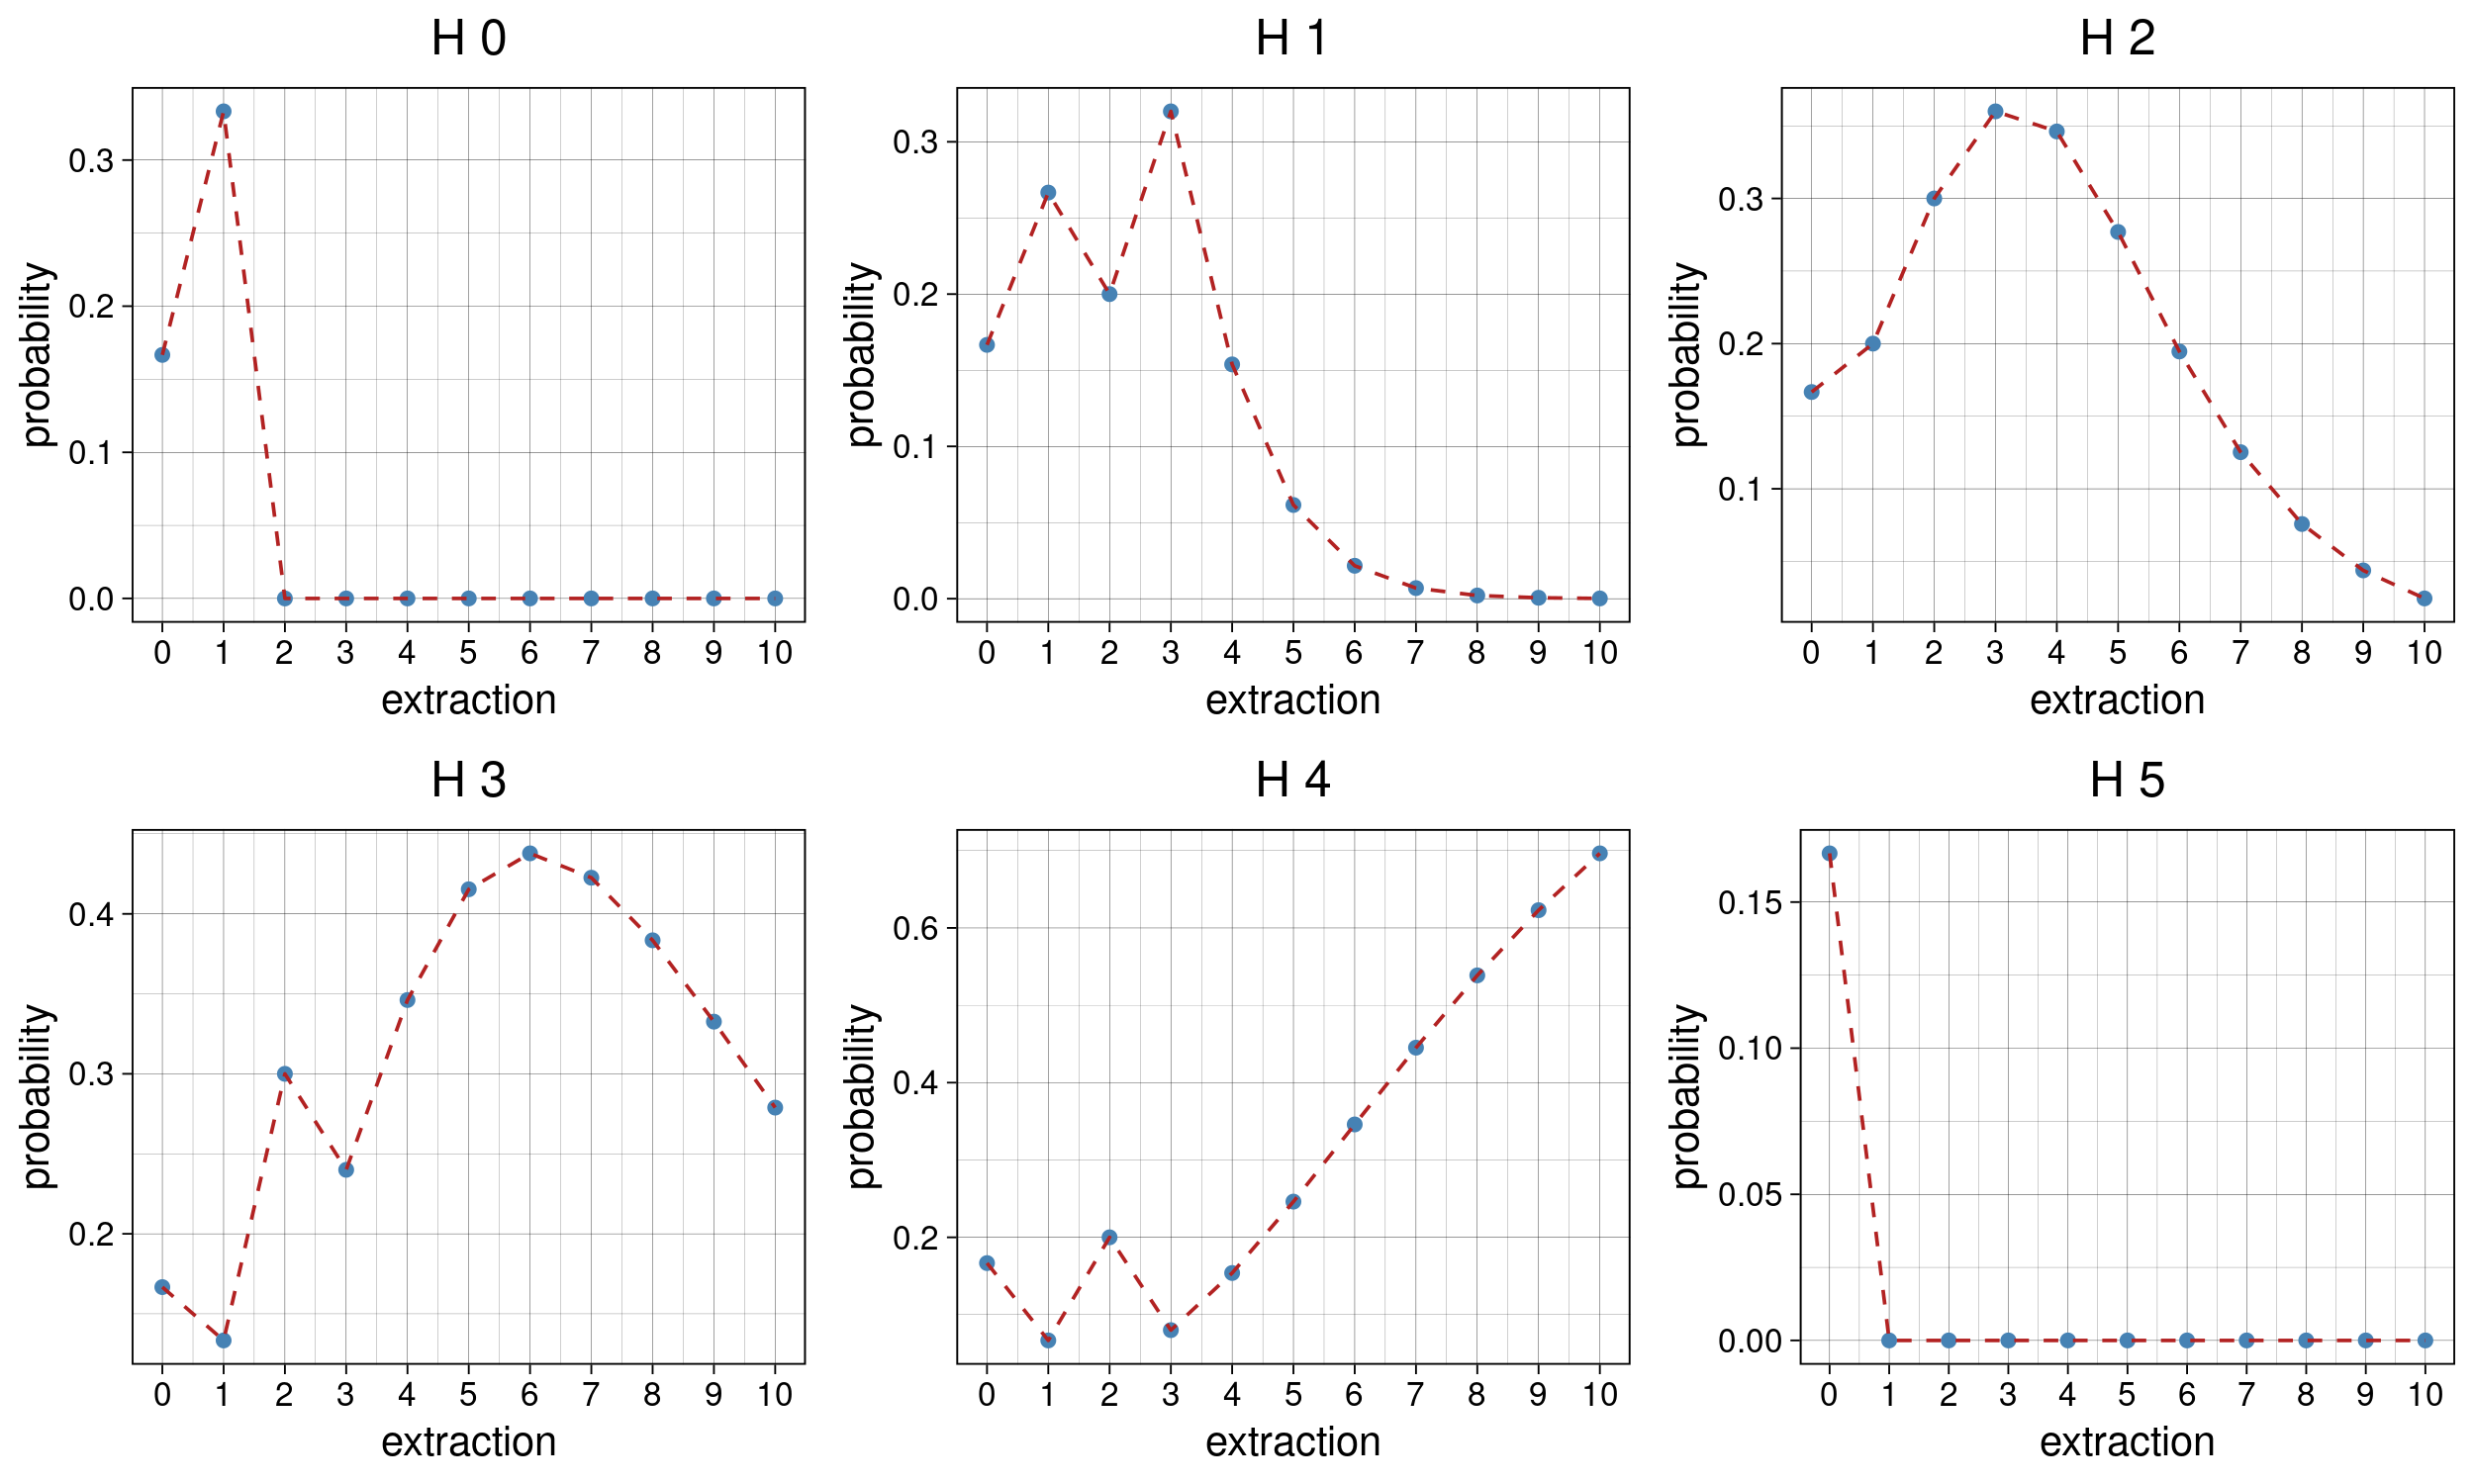

In [ ]:
#plot
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 250)

j <- 0:(n_ext)
plots <- list()
for (i in 0:5 ){
    plot <- ggplot() +
                geom_point(aes(j, df[,(i+1)]), color="steelblue")+
                geom_line(aes(j, df[,(i+1)]), color="firebrick", linetype="dashed")+
                theme_linedraw()+
                labs(x="extraction", y="probability")+
                ggtitle(paste("H",i))+
                scale_x_continuous(breaks=j)+
                theme(plot.title = element_text(hjust = 0.5), text=element_text(size=12))
    
    plots[[i+1]] = ggplotGrob(plot)
    
}
grid.arrange(grobs=plots, ncol=3, nrow=2)

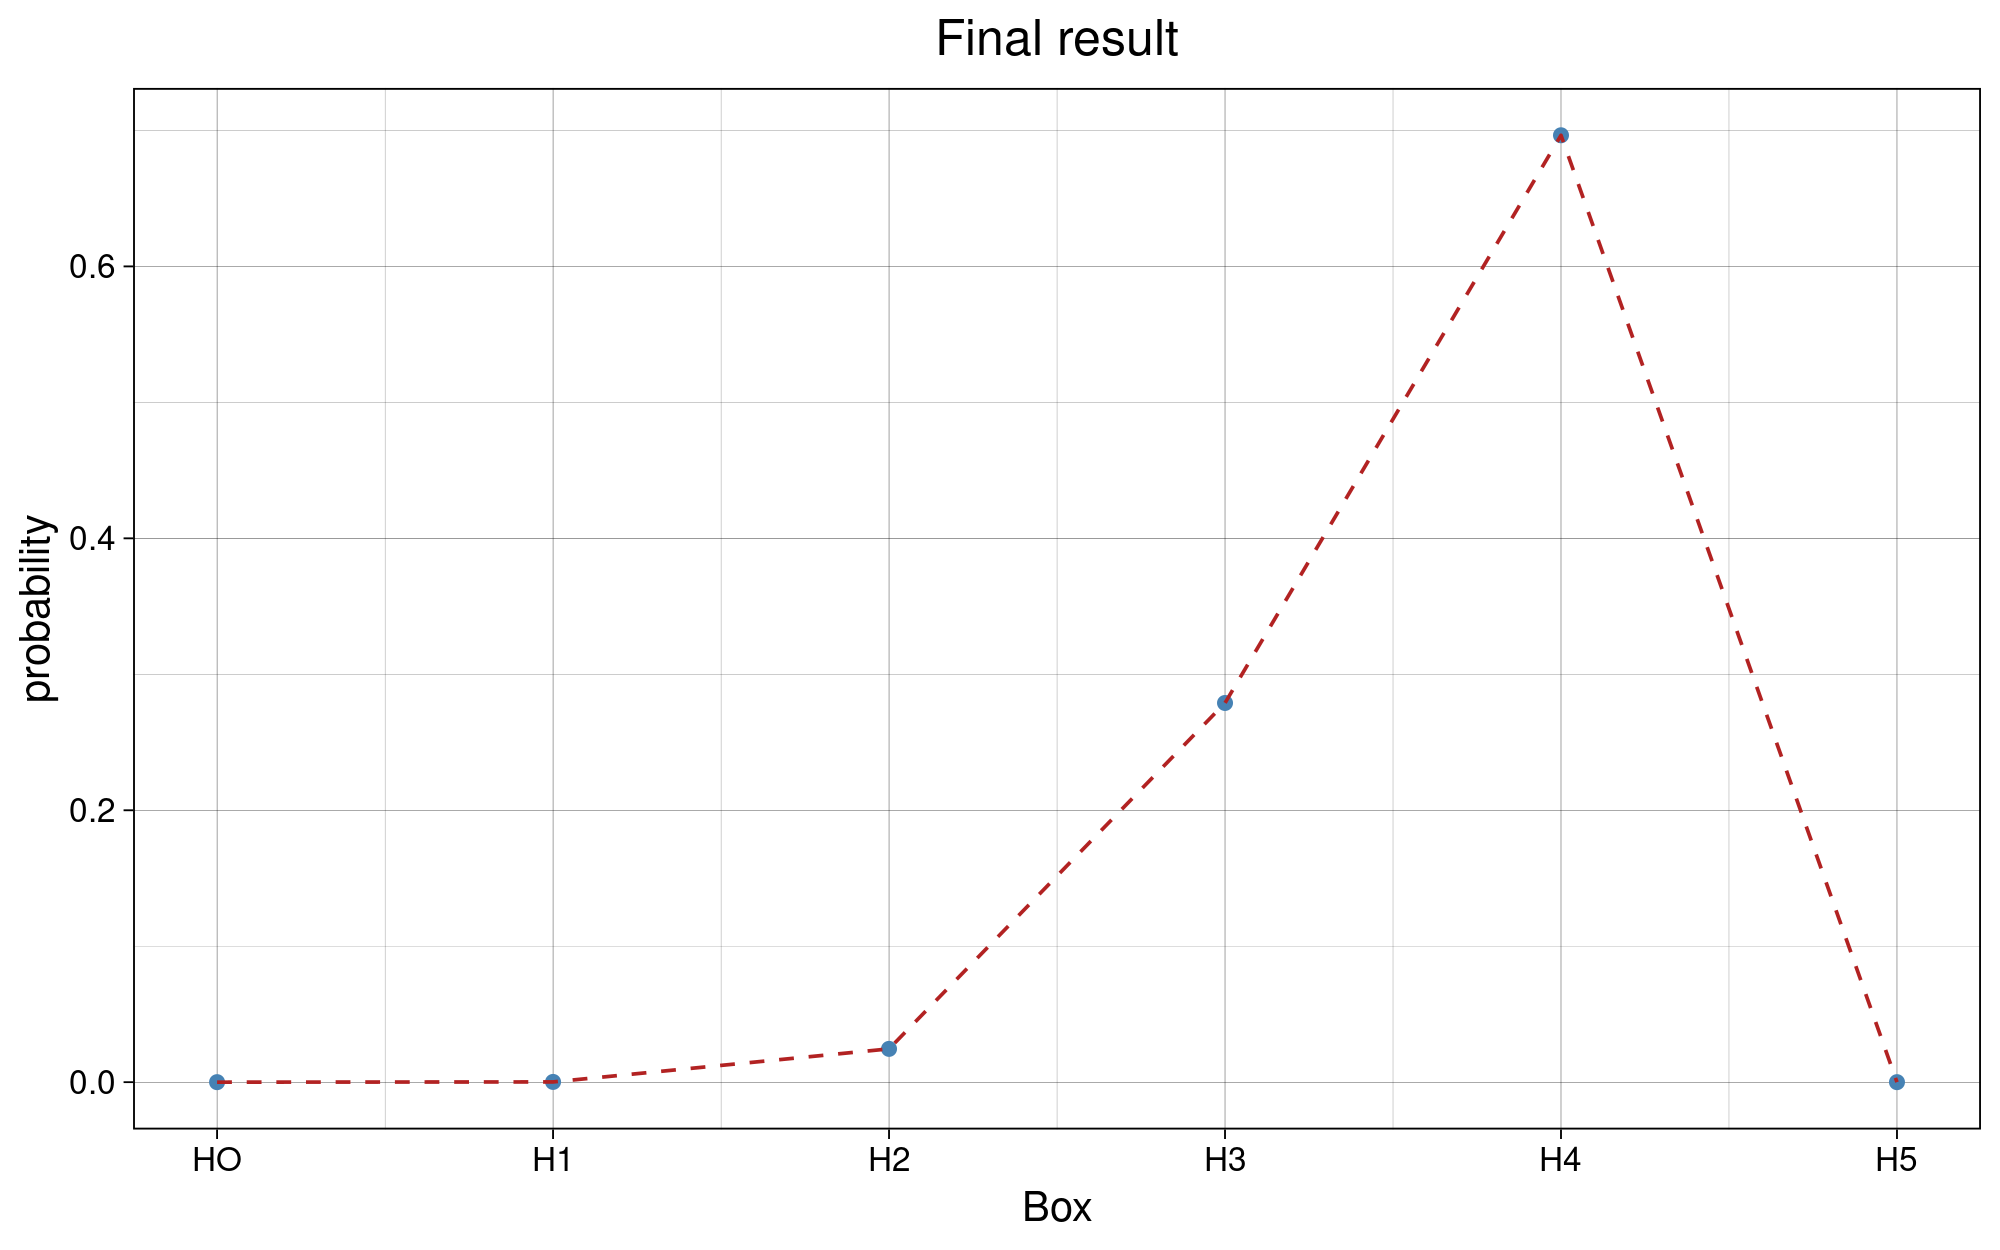

In [ ]:
#Plotting the final prior at the end of the extraction
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 250)

box <- 0:5
plot <- ggplot() +
            geom_point(aes( box , unlist(tail(df,1))), color="steelblue")+
            geom_line(aes(box , unlist(tail(df,1))), color="firebrick", linetype="dashed")+
            theme_linedraw()+
            labs(title = "Final result",x="Box", y="probability")+
            theme(plot.title = element_text(hjust = 0.5), text=element_text(size=12))+
            scale_x_continuous(breaks=box, labels=c("HO","H1","H2","H3","H4","H5"))


plot